In [31]:
# Essential imports for ensemble learning pipeline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models, transforms
import timm  # For Xception and other models

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Machine learning utilities
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Genetic algorithm for hyperparameter optimization
import deap
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm
import time

# --- Step 1: FastMRI to DICOM ---
import datetime
import os
from pathlib import Path
import h5py
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import generate_uid
import xmltodict

import pydicom
import numpy as np
from PIL import Image
from pathlib import Path
import os

from pathlib import Path

In [32]:
def fastmri_to_dicom(filename: Path,
    reconstruction_name: str,
    outfolder: Path,
    flip_up_down: bool = False,
    flip_left_right: bool = False) -> None:
    fileparts = os.path.splitext(filename.name)
    patientName = fileparts[0]
    f = h5py.File(filename,'r')
    if not outfolder:
        outfolder = Path(patientName)
        outfolder.mkdir(parents=True, exist_ok=True)
    if 'ismrmrd_header' not in f.keys():
        raise Exception('ISMRMRD header not found in file')
    if reconstruction_name not in f.keys():
        raise Exception('Reconstruction name not found in file')
    head = xmltodict.parse(f['ismrmrd_header'][()])
    reconSpace = head['ismrmrdHeader']['encoding']['reconSpace']
    measurementInformation = head['ismrmrdHeader']['measurementInformation']
    acquisitionSystemInformation = head['ismrmrdHeader']['acquisitionSystemInformation']
    H1resonanceFrequency_Hz = head['ismrmrdHeader']['experimentalConditions']['H1resonanceFrequency_Hz']
    sequenceParameters = head['ismrmrdHeader']['sequenceParameters']
    pixelSizeX = float(reconSpace['fieldOfView_mm']['x'])/float(reconSpace['matrixSize']['x'])
    pixelSizeY = float(reconSpace['fieldOfView_mm']['y'])/float(reconSpace['matrixSize']['y'])
    img_data = f[reconstruction_name][:]
    slices = img_data.shape[0]
    if flip_left_right:
        img_data = img_data[:, :, ::-1]
    if flip_up_down:
        img_data = img_data[:, ::-1, :]
    image_max = 1024
    scale = image_max / np.percentile(img_data, 99.9)
    pixels_scaled = np.clip((scale * img_data), 0, image_max).astype('int16')
    windowWidth = 2 * (np.percentile(pixels_scaled, 99.9) - np.percentile(pixels_scaled, 0.1))
    windowCenter = windowWidth/2
    studyInstanceUid = generate_uid('999.')
    seriesInstanceUid = generate_uid('9999.')
    for s in range(0, slices):
        slice_filename = "%s_%03d.dcm"%(patientName, s)
        slice_full_path = outfolder/slice_filename
        slice_pixels = pixels_scaled[s,:,:]
        file_meta = FileMetaDataset()
        file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
        file_meta.MediaStorageSOPInstanceUID = "1.2.3"
        file_meta.ImplementationClassUID = "1.2.3.4"
        file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
        ds = Dataset()
        dt = datetime.datetime.now()
        ds.ContentDate = dt.strftime('%Y%m%d')
        timeStr = dt.strftime('%H%M%S.%f')
        ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
        ds.SOPInstanceUID = generate_uid('9999.')
        ds.ContentTime = timeStr
        ds.Modality = 'MR'
        ds.ModalitiesInStudy = ['', 'PR', 'MR', '']
        ds.StudyDescription = measurementInformation['protocolName']
        ds.PatientName = patientName
        ds.PatientID = patientName
        ds.PatientBirthDate = '19700101'
        ds.PatientSex = 'M'
        ds.PatientAge = '030Y'
        ds.PatientIdentityRemoved = 'YES'
        ds.MRAcquisitionType = '2D'
        ds.SequenceName = sequenceParameters['sequence_type']
        ds.SliceThickness = reconSpace['fieldOfView_mm']['z']
        ds.RepetitionTime = sequenceParameters['TR']
        ds.EchoTime = sequenceParameters['TE']
        ds.ImagingFrequency = H1resonanceFrequency_Hz
        ds.ImagedNucleus = '1H'
        ds.EchoNumbers = "1"
        ds.MagneticFieldStrength = acquisitionSystemInformation['systemFieldStrength_T']
        ds.SpacingBetweenSlices = reconSpace['fieldOfView_mm']['z']
        ds.FlipAngle = str(sequenceParameters['flipAngle_deg'])
        ds.PatientPosition = measurementInformation['patientPosition']
        ds.StudyInstanceUID = studyInstanceUid
        ds.SeriesInstanceUID = seriesInstanceUid
        ds.StudyID = measurementInformation['measurementID']
        ds.InstanceNumber = str(s+1)
        ds.ImagesInAcquisition = str(slices)
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = 'MONOCHROME2'
        ds.NumberOfFrames = "1"
        ds.Rows = slice_pixels.shape[0]
        ds.Columns = slice_pixels.shape[1]
        ds.PixelSpacing = [pixelSizeX, pixelSizeY]
        ds.PixelAspectRatio = [1, 1]
        ds.BitsAllocated = 16
        ds.BitsStored = 12
        ds.HighBit = 11
        ds.PixelRepresentation = 1 
        ds.SmallestImagePixelValue = 0
        ds.LargestImagePixelValue = 1024
        ds.BurnedInAnnotation = 'NO'
        ds.WindowCenter = str(windowCenter)
        ds.WindowWidth = str(windowWidth)
        ds.LossyImageCompression = '00'
        ds.StudyStatusID = 'COMPLETED'
        ds.ResultsID = ''
        # NOTE: The following method may need to be replaced with ds.PixelData assignment depending on pydicom version
        ds.set_pixel_data(slice_pixels, 'MONOCHROME2', 12)
        ds.file_meta = file_meta
        ds.is_implicit_VR = False
        ds.is_little_endian = True
        ds.save_as(slice_full_path, write_like_original=False)
# Example usage
# fastmri_to_dicom(Path("/mnt/f/datasets/demo_data/file1000002.h5"), "reconstruction_rss", Path("output"), True, False)

In [33]:
# --- Step 2: DICOM to PNG ---

def dicom_to_png(dicom_path, output_path=None, apply_windowing=True, normalize=True):
    """
    Convert a DICOM file to PNG format.
    Args:
        dicom_path (str or Path): Path to the DICOM file
        output_path (str or Path, optional): Output PNG file path. If None, uses same name as DICOM with .png extension
        apply_windowing (bool): Whether to apply DICOM windowing (window center/width)
        normalize (bool): Whether to normalize pixel values to 0-255 range
    Returns:
        str: Path to the saved PNG file
    """
    dicom_path = Path(dicom_path)
    if not dicom_path.exists():
        raise FileNotFoundError(f"DICOM file not found: {dicom_path}")
    ds = pydicom.dcmread(dicom_path)
    pixel_array = ds.pixel_array
    if ds.PixelRepresentation == 1:
        pixel_array = pixel_array.astype(np.int16)
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        pixel_array = pixel_array * ds.RescaleSlope + ds.RescaleIntercept
    if apply_windowing and hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
        window_center = float(ds.WindowCenter) if isinstance(ds.WindowCenter, (int, float, str)) else float(ds.WindowCenter[0])
        window_width = float(ds.WindowWidth) if isinstance(ds.WindowWidth, (int, float, str)) else float(ds.WindowWidth[0])
        window_min = window_center - window_width / 2
        window_max = window_center + window_width / 2
        pixel_array = np.clip(pixel_array, window_min, window_max)
        pixel_array = (pixel_array - window_min) / (window_max - window_min) * 255
    elif normalize:
        pixel_min = np.min(pixel_array)
        pixel_max = np.max(pixel_array)
        if pixel_max > pixel_min:
            pixel_array = (pixel_array - pixel_min) / (pixel_max - pixel_min) * 255
        else:
            pixel_array = np.zeros_like(pixel_array)
    pixel_array = pixel_array.astype(np.uint8)
    if len(pixel_array.shape) == 3:
        print(f"Multi-frame DICOM detected with {pixel_array.shape[0]} frames")
        output_dir = output_path.parent if output_path else dicom_path.parent
        base_name = output_path.stem if output_path else dicom_path.stem
        saved_files = []
        for i, frame in enumerate(pixel_array):
            frame_output = output_dir / f"{base_name}_frame_{i:03d}.png"
            if len(frame.shape) == 2:
                img = Image.fromarray(frame, mode='L')
            else:
                img = Image.fromarray(frame)
            img.save(frame_output)
            saved_files.append(str(frame_output))
            print(f"Saved frame {i}: {frame_output}")
        return saved_files
    else:
        if output_path is None:
            output_path = dicom_path.with_suffix('.png')
        else:
            output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        if len(pixel_array.shape) == 2:
            img = Image.fromarray(pixel_array, mode='L')
        else:
            img = Image.fromarray(pixel_array)
        img.save(output_path)
        print(f"Saved: {output_path}")
        return str(output_path)

def process_directory(input_dir, output_dir=None, apply_windowing=True, normalize=True):
    input_dir = Path(input_dir)
    if output_dir is None:
        output_dir = input_dir / "png_output"
    else:
        output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    dicom_extensions = ['.dcm', '.dicom', '.ima', '']
    dicom_files = []
    for ext in dicom_extensions:
        if ext:
            dicom_files.extend(input_dir.glob(f"*{ext}"))
        else:
            for file in input_dir.iterdir():
                if file.is_file() and not file.suffix:
                    try:
                        pydicom.dcmread(file, stop_before_pixels=True)
                        dicom_files.append(file)
                    except:
                        continue
    if not dicom_files:
        print(f"No DICOM files found in {input_dir}")
        return
    print(f"Found {len(dicom_files)} DICOM files")
    for dicom_file in dicom_files:
        try:
            output_path = output_dir / f"{dicom_file.stem}.png"
            dicom_to_png(dicom_file, output_path, apply_windowing, normalize)
        except Exception as e:
            print(f"Error processing {dicom_file}: {e}")
# Example usage
# process_directory("output", "png-output", True, True)

In [34]:
# Step 1: Convert FastMRI HDF5 to DICOM slices
fastmri_h5_path = Path("/mnt/f/datasets/demo_data/file1000002.h5")  # Update path as needed
output_dicom_dir = Path("output")
# fastmri_to_dicom(fastmri_h5_path, "reconstruction_rss", output_dicom_dir, flip_up_down=True, flip_left_right=False)

# Step 2: Convert DICOM slices to PNG images
output_png_dir = Path("png-output")
process_directory(Path("/home/bictor0301/Code/JointWise/output-folder"), output_png_dir, apply_windowing=True, normalize=True)

print("Pipeline complete. DICOM files are in 'output/', PNG files are in 'png-output/'.")

Found 14012 DICOM files
Saved: png-output/file1002495_007.png
Saved: png-output/file1002497_026.png
Saved: png-output/file1001226_023.png
Saved: png-output/file1000408_021.png
Saved: png-output/file1001692_019.png
Saved: png-output/file1000639_032.png
Saved: png-output/file1001024_010.png
Saved: png-output/file1002505_007.png
Saved: png-output/file1001699_004.png
Saved: png-output/file1002146_039.png
Saved: png-output/file1000313_018.png
Saved: png-output/file1002088_016.png
Saved: png-output/file1001079_025.png
Saved: png-output/file1000311_005.png
Saved: png-output/file1000393_000.png
Saved: png-output/file1000015_017.png
Saved: png-output/file1000931_009.png
Saved: png-output/file1000311_008.png
Saved: png-output/file1000495_033.png
Saved: png-output/file1002358_026.png
Saved: png-output/file1002030_009.png
Saved: png-output/file1001311_019.png
Saved: png-output/file1001113_003.png
Saved: png-output/file1001387_025.png
Saved: png-output/file1000931_019.png
Saved: png-output/file1000

In [65]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
random.seed(42)

# Set deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Environment setup complete.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"Using device: {device}")


Environment setup complete.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060
CUDA memory: 12.0 GB
Using device: cuda


In [67]:
# Load and process annotations from knee.csv
class DataProcessor:
    def __init__(self, csv_path, png_dir):
        self.csv_path = Path(csv_path)
        self.png_dir = Path(png_dir)
        self.df = None
        self.subject_labels = {}
        
    def load_annotations(self):
        """Load and process knee annotations"""
        self.df = pd.read_csv(self.csv_path)
        print(f"Loaded {len(self.df)} annotations")
        print(f"Unique files: {self.df['file'].nunique()}")
        print(f"Label distribution:")
        print(self.df['label'].value_counts())
        return self.df
    
    def create_target_labels(self):
        """Create target labels: ACL tear, Meniscus tear, Neither"""
        # Map detailed labels to our target classes
        acl_keywords = ['ACL', 'Anterior Cruciate', 'Anterior Cruciate Ligament', 'ACL High Grade Sprain', 'ACL Low Grade sprain']
        meniscus_keywords = ['Meniscus', 'Meniscus Tear']
        
        subject_conditions = {}
        
        for file_id in self.df['file'].unique():
            file_data = self.df[self.df['file'] == file_id]
            labels = file_data['label'].tolist()
            
            has_acl = any(any(keyword.lower() in label.lower() for keyword in acl_keywords) for label in labels)
            has_meniscus = any(any(keyword.lower() in label.lower() for keyword in meniscus_keywords) for label in labels)
            
            if has_acl and has_meniscus:
                subject_conditions[file_id] = 'Both'  # We'll handle this case
            elif has_acl:
                subject_conditions[file_id] = 'ACL_tear'
            elif has_meniscus:
                subject_conditions[file_id] = 'Meniscus_tear'
            else:
                subject_conditions[file_id] = 'Neither'
        
        self.subject_labels = subject_conditions
        print("\nSubject-level label distribution:")
        label_counts = pd.Series(list(subject_conditions.values())).value_counts()
        print(label_counts)
        
        return subject_conditions
    
    def get_bounding_boxes(self, file_id, slice_num):
        """Get bounding boxes for a specific file and slice"""
        slice_data = self.df[(self.df['file'] == file_id) & (self.df['slice'] == slice_num)]
        boxes = []
        for _, row in slice_data.iterrows():
            boxes.append({
                'x': row['x'], 'y': row['y'], 
                'width': row['width'], 'height': row['height'],
                'label': row['label']
            })
        return boxes
    
    def get_available_images(self):
        """Get list of available PNG images with their labels"""
        available_images = []
        
        for png_file in self.png_dir.glob('*.png'):
            # Extract file ID and slice from filename (e.g., file1000002_000.png)
            filename = png_file.stem
            parts = filename.split('_')
            if len(parts) >= 2:
                file_id = '_'.join(parts[:-1])  # Everything except last part
                slice_num = int(parts[-1])  # Last part is slice number
                
                if file_id in self.subject_labels:
                    available_images.append({
                        'path': str(png_file),
                        'file_id': file_id,
                        'slice': slice_num,
                        'label': self.subject_labels[file_id]
                    })
        
        print(f"\nFound {len(available_images)} available images")
        return available_images

# Initialize data processor
data_processor = DataProcessor('/home/bictor0301/Code/JointWise/annotations/knee.csv', '/home/bictor0301/Code/JointWise/png-output')
annotations = data_processor.load_annotations()
subject_labels = data_processor.create_target_labels()
available_images = data_processor.get_available_images()

print(f"\nReady to process {len(available_images)} images from {len(subject_labels)} subjects")

Loaded 16167 annotations
Unique files: 974
Label distribution:
label
Meniscus Tear                                5658
Cartilage - Partial Thickness loss/defect    2985
Joint Effusion                               1311
Bone-Fracture/Contusion/dislocation          1060
Bone- Subchondral edema                       986
Periarticular cysts                           864
Ligament - ACL Low Grade sprain               765
Ligament - ACL High Grade Sprain              677
Cartilage - Full Thickness loss/defect        615
Ligament - MCL Low-Mod Grade Sprain           285
Displaced Meniscal Tissue                     232
Bone - Lesion                                 183
Ligament - PCL Low-Mod grade sprain           142
LCL Complex - Low-Mod Grade Sprain            130
Soft Tissue Lesion                             90
Muscle Strain                                  65
Joint Bodies                                   38
Patellar Retinaculum - High grade sprain       24
Ligament - PCL High Grade      

In [68]:
# Data Augmentation for MRI Scans using Albumentations
class MRIAugmentation:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        
    def get_train_augmentation(self):
        """Augmentation pipeline for training data - appropriate for MRI"""
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            
            # Geometric transformations (conservative for medical images)
            A.HorizontalFlip(p=0.5),  # Anatomically valid
            A.Rotate(limit=10, p=0.3),  # Small rotations only
            A.ShiftScaleRotate(
                shift_limit=0.05, 
                scale_limit=0.05, 
                rotate_limit=5, 
                p=0.3
            ),
            
            # Intensity transformations (important for MRI)
            A.RandomBrightnessContrast(
                brightness_limit=0.1, 
                contrast_limit=0.1, 
                p=0.3
            ),
            A.RandomGamma(gamma_limit=(90, 110), p=0.2),
            
            # Noise and blur (simulate acquisition variations)
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.GaussianBlur(blur_limit=(1, 3), p=0.1),
            
            # Elastic deformation (subtle tissue deformation)
            A.ElasticTransform(
                alpha=30,
                sigma=5,
                alpha_affine=3,
                p=0.1
            ),
            
            # Normalization
            A.Normalize(
                mean=[0.485],  # Grayscale
                std=[0.229],
                max_pixel_value=255.0
            )
        ])
    
    def get_val_augmentation(self):
        """Augmentation pipeline for validation/test data"""
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            A.Normalize(
                mean=[0.485],
                std=[0.229],
                max_pixel_value=255.0
            )
        ])

# Initialize augmentation
augmentation = MRIAugmentation(image_size=(224, 224))
train_transform = augmentation.get_train_augmentation()
val_transform = augmentation.get_val_augmentation()

print("MRI-specific augmentation pipeline created.")
print("Train augmentations: Flip, Rotate, Brightness/Contrast, Noise, Blur")
print("Validation augmentations: Resize, Normalize only")


MRI-specific augmentation pipeline created.
Train augmentations: Flip, Rotate, Brightness/Contrast, Noise, Blur
Validation augmentations: Resize, Normalize only


In [69]:
# Perform subject-level splitting
splitter = SubjectLevelSplitter(available_images, test_size=0.2, val_size=0.2)
train_data, val_data, test_data = splitter.split_subjects()

# Balance training data (optional - you can choose undersample or oversample)
train_data_balanced = splitter.balance_classes(train_data, method='oversample')

# Filter out 'Both' and 'Neither' from all splits
train_data_balanced = [item for item in train_data_balanced if item['label'] in ['ACL_tear', 'Meniscus_tear']]
val_data = [item for item in val_data if item['label'] in ['ACL_tear', 'Meniscus_tear']]
test_data = [item for item in test_data if item['label'] in ['ACL_tear', 'Meniscus_tear']]

print(f"\nFinal dataset sizes:")
print(f"Balanced Train: {len(train_data_balanced)}")
print(f"Val: {len(val_data)}")
print(f"Test: {len(test_data)}")


Total subjects: 329
Label distribution across subjects:
Meniscus_tear    165
Neither           74
Both              61
ACL_tear          29
Name: count, dtype: int64

Data split completed:
Train: 7105 images from 197 subjects
Val: 2374 images from 66 subjects
Test: 2390 images from 66 subjects

Train label distribution:
Meniscus_tear    3612
Neither          1532
Both             1354
ACL_tear          607
Name: count, dtype: int64

Val label distribution:
Meniscus_tear    1207
Neither           507
Both              430
ACL_tear          230
Name: count, dtype: int64

Test label distribution:
Meniscus_tear    1203
Neither           533
Both              450
ACL_tear          204
Name: count, dtype: int64

Class distribution before balancing:
ACL_tear: 607
Both: 1354
Meniscus_tear: 3612
Neither: 1532

Class distribution after oversample:
ACL_tear         3612
Meniscus_tear    3612
Both             3612
Neither          3612
Name: count, dtype: int64

Final dataset sizes:
Balanced Train

In [70]:
# PyTorch Dataset for Efficient Loading
class MRIDataset(Dataset):
    def __init__(self, data, transform=None, num_classes=2):
        self.data = data
        self.transform = transform
        self.num_classes = num_classes
        
        # Fixed binary class order
        self.fixed_classes = np.array(['ACL_tear', 'Meniscus_tear'])
        
        # Create label encoder with fixed classes
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.fixed_classes)
        
        # Pre-encode all labels; unknowns mapped later (shouldn't occur)
        all_labels = [item['label'] for item in data]
        self.encoded_labels = self.label_encoder.transform(all_labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not load image {item['path']}")
            image = np.zeros((224, 224), dtype=np.uint8)
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.transform:
            augmented = self.transform(image=image_rgb)
            image_rgb = augmented['image']
        
        if isinstance(image_rgb, np.ndarray):
            if len(image_rgb.shape) == 3 and image_rgb.shape[2] == 3:
                image_tensor = torch.from_numpy(image_rgb.transpose(2, 0, 1)).float()
            else:
                image_rgb = image_rgb.astype(np.float32) / 255.0
                if len(image_rgb.shape) == 2:
                    image_rgb = np.stack([image_rgb] * 3, axis=0)
                else:
                    image_rgb = image_rgb.transpose(2, 0, 1)
                image_tensor = torch.from_numpy(image_rgb).float()
        else:
            image_tensor = image_rgb
        
        label = self.encoded_labels[idx]
        return image_tensor, label
    
    def get_labels(self):
        return [item['label'] for item in self.data]
    
    def get_class_weights(self):
        labels = self.get_labels()
        # Ensure only the two classes present
        labels = [l if l in self.fixed_classes else 'ACL_tear' for l in labels]
        label_encoded = self.label_encoder.transform(labels)
        classes = np.arange(self.num_classes)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=label_encoded
        )
        return torch.FloatTensor(class_weights).to(device)
    
    def get_weighted_sampler(self):
        labels = self.encoded_labels
        class_counts = np.bincount(labels, minlength=self.num_classes)
        class_weights = 1.0 / np.maximum(class_counts, 1)
        sample_weights = class_weights[labels]
        
        return WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

# Update augmentation to work with PyTorch
class MRIAugmentationPyTorch:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        
    def get_train_augmentation(self):
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            A.RandomGamma(gamma_limit=(90, 110), p=0.2),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.GaussianBlur(blur_limit=(1, 3), p=0.1),
            A.ElasticTransform(alpha=30, sigma=5, alpha_affine=3, p=0.1),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
            ToTensorV2()
        ])
    
    def get_val_augmentation(self):
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
            ToTensorV2()
        ])

# Create PyTorch datasets and dataloaders
print("Creating PyTorch datasets and dataloaders...")

augmentation = MRIAugmentationPyTorch(image_size=(224, 224))
train_transform = augmentation.get_train_augmentation()
val_transform = augmentation.get_val_augmentation()

train_dataset = MRIDataset(train_data_balanced, transform=train_transform, num_classes=2)
val_dataset = MRIDataset(val_data, transform=val_transform, num_classes=2)
test_dataset = MRIDataset(test_data, transform=val_transform, num_classes=2)

batch_size = 16
train_sampler = train_dataset.get_weighted_sampler()

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler,
    num_workers=4, pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True if torch.cuda.is_available() else False
)

class_weights = train_dataset.get_class_weights()

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")
print(f"Class weights (2 classes): {class_weights}")
print(f"Label encoding: {dict(zip(train_dataset.label_encoder.classes_, range(len(train_dataset.label_encoder.classes_))))}")

Creating PyTorch datasets and dataloaders...
Train loader: 452 batches
Val loader: 90 batches
Test loader: 88 batches
Class weights (2 classes): tensor([1., 1.], device='cuda:0')
Label encoding: {np.str_('ACL_tear'): 0, np.str_('Meniscus_tear'): 1}


In [81]:
# Base Model Architectures in PyTorch
class BaseModelBuilder:
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
    
    def build_resnext50(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.resnext50_32x4d(pretrained=True)
        except Exception:
            model = models.resnext50_32x4d(pretrained=False)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_densenet201(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.densenet201(pretrained=True)
        except Exception:
            model = models.densenet201(pretrained=False)
        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_efficientnet_b7(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.efficientnet_b7(pretrained=True)
        except Exception:
            model = models.efficientnet_b7(pretrained=False)
        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_xception(self, dropout_rate=0.5, freeze_backbone=True):
        model = timm.create_model('xception41', pretrained=True)
        # Prefer timm reset_classifier API if available
        if hasattr(model, 'get_classifier') and hasattr(model, 'reset_classifier'):
            in_ch = model.get_classifier().in_features
            model.reset_classifier(num_classes=self.num_classes, global_pool='avg')
            if freeze_backbone:
                # Freeze all but classifier params
                clf_names = set()
                # Try to infer names used by timm for classifier params
                for name, _ in model.named_parameters():
                    if 'classifier' in name or 'head' in name or name.endswith('fc.weight') or name.endswith('fc.bias'):
                        parts = name.split('.')
                        if parts:
                            clf_names.add(parts[0])
                for name, param in model.named_parameters():
                    if not ('classifier' in name or 'head' in name or name.endswith('fc.weight') or name.endswith('fc.bias')):
                        param.requires_grad = False
            return model
        # Fallback manual head replacement
        if hasattr(model, 'classifier') and hasattr(model.classifier, 'in_features'):
            num_features = model.classifier.in_features
            new_head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, self.num_classes)
            )
            model.classifier = new_head
        elif hasattr(model, 'head') and hasattr(model.head, 'in_features'):
            num_features = model.head.in_features
            model.head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, self.num_classes)
            )
        elif hasattr(model, 'fc') and hasattr(model.fc, 'in_features'):
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, self.num_classes)
        else:
            raise AttributeError("Unsupported xception head layout")
        if freeze_backbone:
            for name, param in model.named_parameters():
                if not any(k in name for k in ['classifier', 'head', 'fc']):
                    param.requires_grad = False
        return model
    
    def get_model_by_name(self, model_name, **kwargs):
        if model_name == 'resnext50':
            return self.build_resnext50(**kwargs)
        elif model_name == 'densenet201':
            return self.build_densenet201(**kwargs)
        elif model_name == 'efficientnet_b7':
            return self.build_efficientnet_b7(**kwargs)
        elif model_name == 'xception':
            return self.build_xception(**kwargs)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

class PyTorchTrainer:
    def __init__(self, model, device, class_weights=None):
        self.model = model.to(device)
        self.device = device
        self.class_weights = class_weights
        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()
        self.training_history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
    
    def train_epoch(self, train_loader, optimizer):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            train_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / max(total, 1)
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / max(total, 1)
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader, epochs=50, learning_rate=1e-4,
              patience=10, save_path=None):
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Robust scheduler across torch versions
        try:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
        except TypeError:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        best_val_acc = 0.0
        patience_counter = 0
        print(f"Starting training for {epochs} epochs...")
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 30)
            train_loss, train_acc = self.train_epoch(train_loader, optimizer)
            val_loss, val_acc = self.validate_epoch(val_loader)
            scheduler.step(val_acc)
            self.training_history['train_loss'].append(train_loss)
            self.training_history['train_acc'].append(train_acc)
            self.training_history['val_loss'].append(val_loss)
            self.training_history['val_acc'].append(val_acc)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                if save_path:
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Model saved to {save_path}")
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.4f}")
        return self.training_history

# Initialize model builder
model_builder = BaseModelBuilder(num_classes=2)

print("PyTorch model architectures defined:")
print("- ResNeXt-50 (32x4d)")
print("- DenseNet-201")
print("- EfficientNet-B7")
print("- Xception-41")
print("\nAll models use transfer learning with ImageNet pretrained weights and output 2 classes.")

PyTorch model architectures defined:
- ResNeXt-50 (32x4d)
- DenseNet-201
- EfficientNet-B7
- Xception-41

All models use transfer learning with ImageNet pretrained weights and output 2 classes.


In [72]:
# Genetic Algorithm for Hyperparameter Optimization (PyTorch)
class GeneticOptimizerPyTorch:
    def __init__(self, model_name, model_builder, train_loader, val_loader, device):
        self.model_name = model_name
        self.model_builder = model_builder
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.setup_deap()
    
    def setup_deap(self):
        """Setup DEAP genetic algorithm framework"""
        # Create fitness class (maximize validation accuracy)
        if hasattr(creator, 'FitnessMax'):
            del creator.FitnessMax
        if hasattr(creator, 'Individual'):
            del creator.Individual
            
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        
        # Hyperparameter ranges
        self.param_ranges = {
            'learning_rate': (1e-5, 1e-2),
            'dropout_rate': (0.2, 0.7),
            'weight_decay': (1e-6, 1e-3),
            'batch_size': [8, 16, 32]  # Limited options for memory
        }
        
        # Register genetic operators
        self.toolbox.register("learning_rate", random.uniform, *self.param_ranges['learning_rate'])
        self.toolbox.register("dropout_rate", random.uniform, *self.param_ranges['dropout_rate'])
        self.toolbox.register("weight_decay", random.uniform, *self.param_ranges['weight_decay'])
        self.toolbox.register("batch_size", random.choice, self.param_ranges['batch_size'])
        
        self.toolbox.register("individual", tools.initCycle, creator.Individual,
                            (self.toolbox.learning_rate, self.toolbox.dropout_rate,
                             self.toolbox.weight_decay, self.toolbox.batch_size), n=1)
        
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self.evaluate_individual)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", self.mutate_individual, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
    
    def evaluate_individual(self, individual):
        """Evaluate an individual (set of hyperparameters)"""
        learning_rate, dropout_rate, weight_decay, batch_size = individual
        
        try:
            # Build model with current hyperparameters
            model = self.model_builder.get_model_by_name(
                self.model_name, 
                dropout_rate=dropout_rate, 
                freeze_backbone=True
            )
            
            # Create trainer
            trainer = PyTorchTrainer(model, self.device, class_weights)
            
            # Create optimizer
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate, 
                weight_decay=weight_decay
            )
            
            # Quick training for evaluation (reduced epochs)
            model.train()
            total_correct = 0
            total_samples = 0
            
            # Train for a few batches only
            for batch_idx, (data, target) in enumerate(self.train_loader):
                if batch_idx >= 5:  # Limit to 5 batches for speed
                    break
                    
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = trainer.criterion(output, target)
                loss.backward()
                optimizer.step()
            
            # Quick validation
            model.eval()
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(self.val_loader):
                    if batch_idx >= 3:  # Limit validation batches
                        break
                        
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total_samples += target.size(0)
                    total_correct += (predicted == target).sum().item()
            
            val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
            
            # Clean up GPU memory
            del model, trainer, optimizer
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
            return (val_accuracy,)
            
        except Exception as e:
            print(f"Error evaluating individual: {e}")
            # Clean up on error
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            return (0.0,)
    
    def mutate_individual(self, individual, indpb):
        """Mutate an individual"""
        if random.random() < indpb:
            individual[0] = random.uniform(*self.param_ranges['learning_rate'])
        if random.random() < indpb:
            individual[1] = random.uniform(*self.param_ranges['dropout_rate'])
        if random.random() < indpb:
            individual[2] = random.uniform(*self.param_ranges['weight_decay'])
        if random.random() < indpb:
            individual[3] = random.choice(self.param_ranges['batch_size'])
        
        return individual,
    
    def optimize(self, population_size=8, generations=3):
        """Run genetic algorithm optimization"""
        print(f"Starting genetic optimization for {self.model_name}...")
        print(f"Population size: {population_size}, Generations: {generations}")
        
        # Create initial population
        population = self.toolbox.population(n=population_size)
        
        # Track statistics
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)
        
        # Run genetic algorithm
        population, logbook = algorithms.eaSimple(
            population, self.toolbox,
            cxpb=0.7,
            mutpb=0.3,
            ngen=generations,
            stats=stats,
            verbose=True
        )
        
        # Get best individual
        best_individual = tools.selBest(population, 1)[0]
        best_params = {
            'learning_rate': best_individual[0],
            'dropout_rate': best_individual[1],
            'weight_decay': best_individual[2],
            'batch_size': int(best_individual[3]),
            'fitness': best_individual.fitness.values[0]
        }
        
        print(f"\nBest parameters for {self.model_name}:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        
        return best_params, logbook

print("PyTorch Genetic Algorithm optimizer defined.")
print("Ready to optimize hyperparameters for each base model.")
print("Note: Optimization is faster but less thorough due to PyTorch memory management.")


PyTorch Genetic Algorithm optimizer defined.
Ready to optimize hyperparameters for each base model.
Note: Optimization is faster but less thorough due to PyTorch memory management.


In [79]:
# Train Base Models with Optimized Hyperparameters (PyTorch)
class PyTorchModelTrainer:
    def __init__(self, model_builder, train_loader, val_loader, test_loader, class_weights, device):
        self.model_builder = model_builder
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.class_weights = class_weights
        self.device = device
        self.trained_models = {}
        self.training_histories = {}
        self.best_params = {}
    
    def optimize_and_train_model(self, model_name, optimize_hyperparams=True, 
                                default_params=None, epochs=50):
        print(f"\n{'='*50}")
        print(f"Training {model_name.upper()}")
        print(f"{'='*50}")
        
        if optimize_hyperparams:
            optimizer = GeneticOptimizerPyTorch(
                model_name, self.model_builder, 
                self.train_loader, self.val_loader, self.device
            )
            best_params, _ = optimizer.optimize(population_size=4, generations=2)
            self.best_params[model_name] = best_params
        else:
            best_params = default_params or {
                'learning_rate': 1e-4,
                'dropout_rate': 0.5,
                'weight_decay': 1e-4,
                'batch_size': 16
            }
            self.best_params[model_name] = best_params
        
        print(f"\nUsing parameters: {best_params}")
        
        model = self.model_builder.get_model_by_name(
            model_name, dropout_rate=best_params['dropout_rate'], freeze_backbone=True
        )
        
        print(f"Model architecture for {model_name}:")
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        print("\nPhase 1: Training with frozen backbone...")
        trainer = PyTorchTrainer(model, self.device, self.class_weights)
        history1 = trainer.train(
            self.train_loader, self.val_loader,
            epochs=epochs // 2,
            learning_rate=best_params['learning_rate'],
            save_path=f'best_{model_name}_phase1.pth'
        )
        
        print("\nPhase 2: Fine-tuning with unfrozen backbone...")
        if model_name == 'resnext50':
            for param in model.layer4.parameters():
                param.requires_grad = True
        elif model_name == 'densenet201':
            for param in model.features.denseblock4.parameters():
                param.requires_grad = True
        elif model_name == 'efficientnet_b7':
            for param in list(model.features.children())[-3:][0].parameters():
                param.requires_grad = True
        elif model_name == 'xception':
            # For timm xception, unfreeze last stage or keep backbone mostly frozen
            if hasattr(model, 'blocks'):
                for param in model.blocks[-1].parameters():
                    param.requires_grad = True
            elif hasattr(model, 'encoder') and hasattr(model.encoder, 'layers'):
                for param in model.encoder.layers[-1].parameters():
                    param.requires_grad = True
            # If neither exists, rely on classifier-only training
        
        trainer_ft = PyTorchTrainer(model, self.device, self.class_weights)
        history2 = trainer_ft.train(
            self.train_loader, self.val_loader,
            epochs=epochs // 2,
            learning_rate=best_params['learning_rate'] / 10,
            save_path=f'best_{model_name}_final.pth'
        )
        
        combined_history = {k: history1[k] + history2[k] for k in history1.keys()}
        self.trained_models[model_name] = model
        self.training_histories[model_name] = combined_history
        
        print(f"\n{model_name.upper()} training completed!")
        return model, combined_history
    
    def train_all_models(self, optimize_hyperparams=False, epochs=30):
        model_names = ['resnext50', 'densenet201', 'efficientnet_b7', 'xception']
        default_params = {
            'resnext50': {'learning_rate': 1e-4, 'dropout_rate': 0.4, 'weight_decay': 1e-4, 'batch_size': 16},
            'densenet201': {'learning_rate': 1e-4, 'dropout_rate': 0.6, 'weight_decay': 1e-4, 'batch_size': 16},
            'efficientnet_b7': {'learning_rate': 5e-5, 'dropout_rate': 0.5, 'weight_decay': 1e-4, 'batch_size': 8},
            'xception': {'learning_rate': 1e-4, 'dropout_rate': 0.3, 'weight_decay': 1e-4, 'batch_size': 16}
        }
        for model_name in model_names:
            try:
                self.optimize_and_train_model(
                    model_name, 
                    optimize_hyperparams=optimize_hyperparams,
                    default_params=default_params.get(model_name),
                    epochs=epochs
                )
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
            except Exception as e:
                print(f"Error training {model_name}: {e}")
                continue
        print(f"\nTraining completed for {len(self.trained_models)} models.")
        return self.trained_models, self.training_histories
    
    def evaluate_model(self, model, data_loader, model_name):
        model.eval()
        all_preds, all_targets, all_probs = [], [], []
        print(f"Evaluating {model_name}...")
        with torch.no_grad():
            for data, target in tqdm(data_loader, desc='Evaluating'):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                probs = F.softmax(output, dim=1)
                _, preds = torch.max(output, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        return np.array(all_targets), np.array(all_preds), np.array(all_probs)

# Initialize PyTorch trainer
trainer = PyTorchModelTrainer(
    model_builder, train_loader, val_loader, test_loader, class_weights, device
)

print("PyTorch model trainer initialized.")
print("Ready to train base models (binary task).")
print(f"Training will be performed on: {device}")

PyTorch model trainer initialized.
Ready to train base models (binary task).
Training will be performed on: cuda


In [82]:
# Model Evaluation and Metrics (PyTorch)
class PyTorchModelEvaluator:
    def __init__(self, label_encoder, device):
        self.label_encoder = label_encoder
        self.class_names = label_encoder.classes_
        self.device = device
    
    def evaluate_model(self, model, test_loader, model_name):
        """Comprehensive model evaluation"""
        print(f"\n{'='*50}")
        print(f"EVALUATING {model_name.upper()}")
        print(f"{'='*50}")
        
        model.eval()
        all_preds = []
        all_targets = []
        all_probs = []
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Evaluating'):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                
                # Get probabilities and predictions
                probs = F.softmax(output, dim=1)
                _, preds = torch.max(output, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        y_true = np.array(all_targets)
        y_pred = np.array(all_preds)
        y_pred_proba = np.array(all_probs)
        
        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Classification report
        report = classification_report(
            y_true, y_pred, 
            target_names=self.class_names,
            output_dict=True
        )
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))
        
        # ROC AUC for multi-class
        try:
            auc_scores = []
            for i in range(len(self.class_names)):
                y_true_binary = (y_true == i).astype(int)
                auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                auc_scores.append(auc)
                print(f"AUC for {self.class_names[i]}: {auc:.4f}")
            
            macro_auc = np.mean(auc_scores)
            print(f"Macro-averaged AUC: {macro_auc:.4f}")
        except Exception as e:
            print(f"Could not compute AUC: {e}")
            auc_scores = []
            macro_auc = 0
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Store results
        results = {
            'model_name': model_name,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'auc_scores': auc_scores,
            'macro_auc': macro_auc,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        return results
    
    def plot_training_history(self, history, model_name):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{model_name.upper()} Training History', fontsize=16)
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Loss
        axes[0, 0].plot(epochs, history['train_loss'], label='Training')
        axes[0, 0].plot(epochs, history['val_loss'], label='Validation')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Accuracy
        axes[0, 1].plot(epochs, history['train_acc'], label='Training')
        axes[0, 1].plot(epochs, history['val_acc'], label='Validation')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Learning rate (if available)
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nScheduling Applied', 
                        ha='center', va='center', transform=axes[1, 0].transAxes,
                        fontsize=12)
        axes[1, 0].set_title('Learning Rate Schedule')
        
        # Best metrics summary
        best_train_acc = max(history['train_acc'])
        best_val_acc = max(history['val_acc'])
        final_train_loss = history['train_loss'][-1]
        final_val_loss = history['val_loss'][-1]
        
        metrics_text = f"Best Train Acc: {best_train_acc:.4f}\n"
        metrics_text += f"Best Val Acc: {best_val_acc:.4f}\n"
        metrics_text += f"Final Train Loss: {final_train_loss:.4f}\n"
        metrics_text += f"Final Val Loss: {final_val_loss:.4f}"
        
        axes[1, 1].text(0.1, 0.5, metrics_text, transform=axes[1, 1].transAxes,
                        fontsize=11, verticalalignment='center')
        axes[1, 1].set_title('Training Summary')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, cm, model_name):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title(f'{model_name.upper()} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self, results_dict):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(15, 5))
        
        for i, class_name in enumerate(self.class_names):
            plt.subplot(1, 3, i+1)
            
            for model_name, results in results_dict.items():
                if len(results['auc_scores']) > i:
                    y_true_binary = (results['y_true'] == i).astype(int)
                    y_pred_proba_binary = results['y_pred_proba'][:, i]
                    
                    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba_binary)
                    auc = results['auc_scores'][i]
                    
                    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
            
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {class_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_models(self, results_dict):
        """Compare all models performance"""
        comparison_data = []
        
        for model_name, results in results_dict.items():
            comparison_data.append({
                'Model': model_name.capitalize(),
                'Accuracy': results['accuracy'],
                'Macro AUC': results['macro_auc'],
                'Precision (Macro)': results['classification_report']['macro avg']['precision'],
                'Recall (Macro)': results['classification_report']['macro avg']['recall'],
                'F1-Score (Macro)': results['classification_report']['macro avg']['f1-score']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        print("\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        print(comparison_df.to_string(index=False, float_format='%.4f'))
        
        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy comparison
        axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], 
                   color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
        axes[0].set_title('Model Accuracy Comparison')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_ylim(0, 1)
        for i, v in enumerate(comparison_df['Accuracy']):
            axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # Multi-metric comparison
        metrics = ['Accuracy', 'Macro AUC', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
        x = np.arange(len(comparison_df))
        width = 0.15
        
        for i, metric in enumerate(metrics):
            axes[1].bar(x + i*width, comparison_df[metric], width, 
                       label=metric, alpha=0.8)
        
        axes[1].set_title('Multi-Metric Comparison')
        axes[1].set_ylabel('Score')
        axes[1].set_xlabel('Models')
        axes[1].set_xticks(x + width * 2)
        axes[1].set_xticklabels(comparison_df['Model'])
        axes[1].legend()
        axes[1].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        return comparison_df

# Initialize PyTorch evaluator
evaluator = PyTorchModelEvaluator(train_dataset.label_encoder, device)

print("PyTorch model evaluator initialized.")
print("Ready to evaluate trained models and generate comprehensive metrics.")


PyTorch model evaluator initialized.
Ready to evaluate trained models and generate comprehensive metrics.


In [83]:
# Sequential Ensemble Learning Model (PyTorch)
class PyTorchSequentialEnsemble:
    def __init__(self, base_models, model_names, label_encoder, device):
        self.base_models = base_models
        self.model_names = model_names
        self.label_encoder = label_encoder
        self.device = device
        self.ensemble_weights = None
        self.meta_model = None
        self.num_classes = len(label_encoder.classes_)
    
    def extract_features(self, data_loader, verbose=True):
        """Extract features from all base models"""
        if verbose:
            print("Extracting features from base models...")
        
        base_predictions = {}
        
        for name, model in zip(self.model_names, self.base_models):
            if verbose:
                print(f"Extracting features from {name}...")
            
            model.eval()
            predictions = []
            
            with torch.no_grad():
                for data, _ in tqdm(data_loader, desc=f'Extracting {name}', disable=not verbose):
                    data = data.to(self.device)
                    output = model(data)
                    probs = F.softmax(output, dim=1)
                    predictions.append(probs.cpu().numpy())
            
            base_predictions[name] = np.vstack(predictions)
        
        return base_predictions
    
    def simple_voting_ensemble(self, test_loader, voting_type='soft'):
        """Simple voting ensemble (soft or hard voting)"""
        print(f"\nPerforming {voting_type} voting ensemble...")
        
        base_predictions = self.extract_features(test_loader)
        
        if voting_type == 'soft':
            # Average probabilities
            ensemble_pred_proba = np.mean(
                [pred for pred in base_predictions.values()], axis=0
            )
            ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)
        else:
            # Hard voting - majority vote
            hard_predictions = []
            for pred in base_predictions.values():
                hard_predictions.append(np.argmax(pred, axis=1))
            
            ensemble_pred = []
            for i in range(len(hard_predictions[0])):
                votes = [pred[i] for pred in hard_predictions]
                ensemble_pred.append(max(set(votes), key=votes.count))
            
            ensemble_pred = np.array(ensemble_pred)
            ensemble_pred_proba = None
        
        return ensemble_pred, ensemble_pred_proba
    
    def weighted_ensemble(self, val_loader, test_loader, method='accuracy'):
        """Weighted ensemble based on individual model performance"""
        print(f"\nCreating weighted ensemble based on {method}...")
        
        # Get validation predictions for weight calculation
        val_predictions = self.extract_features(val_loader)
        
        # Get true labels
        y_val_true = []
        for _, target in val_loader:
            y_val_true.extend(target.numpy())
        y_val_true = np.array(y_val_true)
        
        # Calculate weights based on performance
        weights = []
        for name, pred in val_predictions.items():
            y_pred = np.argmax(pred, axis=1)[:len(y_val_true)]
            
            if method == 'accuracy':
                weight = accuracy_score(y_val_true, y_pred)
            elif method == 'auc':
                try:
                    auc_scores = []
                    for i in range(self.num_classes):
                        y_true_binary = (y_val_true == i).astype(int)
                        auc = roc_auc_score(y_true_binary, pred[:len(y_val_true), i])
                        auc_scores.append(auc)
                    weight = np.mean(auc_scores)
                except:
                    weight = 0.5  # Fallback weight
            
            weights.append(weight)
            print(f"{name} weight ({method}): {weight:.4f}")
        
        # Normalize weights
        weights = np.array(weights)
        weights = weights / np.sum(weights)
        
        print(f"Normalized weights: {dict(zip(self.model_names, weights))}")
        self.ensemble_weights = weights
        
        # Get test predictions
        test_predictions = self.extract_features(test_loader)
        
        # Weighted average
        weighted_pred_proba = np.zeros_like(list(test_predictions.values())[0])
        for i, (name, pred) in enumerate(test_predictions.items()):
            weighted_pred_proba += weights[i] * pred
        
        ensemble_pred = np.argmax(weighted_pred_proba, axis=1)
        
        return ensemble_pred, weighted_pred_proba
    
    def meta_learner_ensemble(self, train_loader, val_loader, test_loader):
        """Meta-learner ensemble using a neural network"""
        print("\nTraining meta-learner ensemble...")
        
        # Extract features from training set
        print("Extracting training features...")
        train_predictions = self.extract_features(train_loader, verbose=False)
        
        # Prepare meta-training data
        X_meta_train = np.hstack([pred for pred in train_predictions.values()])
        
        # Get true labels for training
        y_meta_train = []
        for _, target in train_loader:
            y_meta_train.extend(target.numpy())
        y_meta_train = np.array(y_meta_train[:len(X_meta_train)])
        
        # Extract features from validation set
        print("Extracting validation features...")
        val_predictions = self.extract_features(val_loader, verbose=False)
        X_meta_val = np.hstack([pred for pred in val_predictions.values()])
        
        # Get true labels for validation
        y_meta_val = []
        for _, target in val_loader:
            y_meta_val.extend(target.numpy())
        y_meta_val = np.array(y_meta_val[:len(X_meta_val)])
        
        # Build meta-model
        meta_input_dim = X_meta_train.shape[1]
        
        class MetaLearner(nn.Module):
            def __init__(self, input_dim, num_classes):
                super(MetaLearner, self).__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_dim, 128),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(64, num_classes)
                )
            
            def forward(self, x):
                return self.layers(x)
        
        self.meta_model = MetaLearner(meta_input_dim, self.num_classes).to(self.device)
        
        # Prepare data for PyTorch
        X_train_tensor = torch.FloatTensor(X_meta_train).to(self.device)
        y_train_tensor = torch.LongTensor(y_meta_train).to(self.device)
        X_val_tensor = torch.FloatTensor(X_meta_val).to(self.device)
        y_val_tensor = torch.LongTensor(y_meta_val).to(self.device)
        
        # Create data loaders for meta-training
        meta_train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        meta_val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
        
        meta_train_loader = DataLoader(meta_train_dataset, batch_size=32, shuffle=True)
        meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=False)
        
        # Train meta-model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.meta_model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        
        print("Training meta-model...")
        meta_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        best_val_acc = 0.0
        patience_counter = 0
        
        for epoch in range(50):
            # Training
            self.meta_model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for X_batch, y_batch in meta_train_loader:
                optimizer.zero_grad()
                outputs = self.meta_model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += y_batch.size(0)
                train_correct += (predicted == y_batch).sum().item()
            
            # Validation
            self.meta_model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for X_batch, y_batch in meta_val_loader:
                    outputs = self.meta_model(X_batch)
                    loss = criterion(outputs, y_batch)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += y_batch.size(0)
                    val_correct += (predicted == y_batch).sum().item()
            
            # Calculate metrics
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            meta_history['train_loss'].append(train_loss / len(meta_train_loader))
            meta_history['train_acc'].append(train_acc)
            meta_history['val_loss'].append(val_loss / len(meta_val_loader))
            meta_history['val_acc'].append(val_acc)
            
            scheduler.step(val_acc)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= 10:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Get test predictions
        print("Generating ensemble predictions...")
        test_predictions = self.extract_features(test_loader, verbose=False)
        X_meta_test = np.hstack([pred for pred in test_predictions.values()])
        X_test_tensor = torch.FloatTensor(X_meta_test).to(self.device)
        
        # Meta-model predictions
        self.meta_model.eval()
        with torch.no_grad():
            ensemble_output = self.meta_model(X_test_tensor)
            ensemble_pred_proba = F.softmax(ensemble_output, dim=1).cpu().numpy()
        
        ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)
        
        return ensemble_pred, ensemble_pred_proba, meta_history
    
    def evaluate_ensemble(self, y_true, y_pred, y_pred_proba, ensemble_name):
        """Evaluate ensemble performance"""
        print(f"\n{'='*50}")
        print(f"ENSEMBLE EVALUATION: {ensemble_name.upper()}")
        print(f"{'='*50}")
        
        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Ensemble Accuracy: {accuracy:.4f}")
        
        # Classification report
        report = classification_report(
            y_true, y_pred,
            target_names=self.label_encoder.classes_,
            output_dict=True
        )
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.label_encoder.classes_))
        
        # AUC scores
        if y_pred_proba is not None:
            try:
                auc_scores = []
                for i in range(self.num_classes):
                    y_true_binary = (y_true == i).astype(int)
                    auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                    auc_scores.append(auc)
                    print(f"AUC for {self.label_encoder.classes_[i]}: {auc:.4f}")
                
                macro_auc = np.mean(auc_scores)
                print(f"Macro-averaged AUC: {macro_auc:.4f}")
            except Exception as e:
                print(f"Could not compute AUC: {e}")
                auc_scores = []
                macro_auc = 0
        else:
            auc_scores = []
            macro_auc = 0
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        results = {
            'ensemble_name': ensemble_name,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'auc_scores': auc_scores,
            'macro_auc': macro_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        return results

print("PyTorch Sequential Ensemble Learning class defined.")
print("Ready to create ensemble models from trained base models.")


PyTorch Sequential Ensemble Learning class defined.
Ready to create ensemble models from trained base models.


Running in FULL mode
Epochs: 40
Hyperparameter optimization: True
Device: cuda

STARTING COMPLETE ENSEMBLE LEARNING PIPELINE (PyTorch)

STEP 1: Training Base Models
----------------------------------------

Training RESNEXT50
Starting genetic optimization for resnext50...
Population size: 4, Generations: 2
gen	nevals	avg     	min     	max  
0  	4     	0.630208	0.333333	0.875
gen	nevals	avg     	min     	max  
0  	4     	0.630208	0.333333	0.875
1  	4     	0.53125 	0.125   	0.875
1  	4     	0.53125 	0.125   	0.875
2  	4     	0.505208	0.125   	0.875

Best parameters for resnext50:
learning_rate: 0.006616020552491424
dropout_rate: 0.5010093645249901
weight_decay: 3.0767422218632275e-05
batch_size: 32
fitness: 0.875

Using parameters: {'learning_rate': 0.006616020552491424, 'dropout_rate': 0.5010093645249901, 'weight_decay': 3.0767422218632275e-05, 'batch_size': 32, 'fitness': 0.875}
2  	4     	0.505208	0.125   	0.875

Best parameters for resnext50:
learning_rate: 0.006616020552491424
dropo

Training: 100%|██████████| 452/452 [00:21<00:00, 21.07it/s, Loss=0.7960, Acc=55.29%]



Train Loss: 0.7960, Train Acc: 0.5529
Val Loss: 0.5841, Val Acc: 0.7029
Model saved to best_resnext50_phase1.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.92it/s, Loss=0.7168, Acc=57.17%]



Train Loss: 0.7168, Train Acc: 0.5717
Val Loss: 0.5891, Val Acc: 0.6862

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.88it/s, Loss=0.6849, Acc=58.53%]


Train Loss: 0.6849, Train Acc: 0.5853
Val Loss: 0.7120, Val Acc: 0.5240

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.88it/s, Loss=0.6729, Acc=58.36%]



Train Loss: 0.6729, Train Acc: 0.5836
Val Loss: 0.8314, Val Acc: 0.3855

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 20.99it/s, Loss=0.6707, Acc=59.25%]



Train Loss: 0.6707, Train Acc: 0.5925
Val Loss: 0.5728, Val Acc: 0.7328
Model saved to best_resnext50_phase1.pth

Epoch 6/20
------------------------------
Model saved to best_resnext50_phase1.pth

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.85it/s, Loss=0.6677, Acc=58.98%]



Train Loss: 0.6677, Train Acc: 0.5898
Val Loss: 0.5726, Val Acc: 0.7168

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.85it/s, Loss=0.6614, Acc=59.93%]


Train Loss: 0.6614, Train Acc: 0.5993
Val Loss: 0.6239, Val Acc: 0.6402

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.89it/s, Loss=0.6630, Acc=60.27%]



Train Loss: 0.6630, Train Acc: 0.6027
Val Loss: 0.5830, Val Acc: 0.6882

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.81it/s, Loss=0.6716, Acc=58.06%]



Train Loss: 0.6716, Train Acc: 0.5806
Val Loss: 0.5716, Val Acc: 0.7634
Model saved to best_resnext50_phase1.pth

Epoch 10/20
------------------------------
Model saved to best_resnext50_phase1.pth

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 21.02it/s, Loss=0.6703, Acc=58.98%]



Train Loss: 0.6703, Train Acc: 0.5898
Val Loss: 0.6785, Val Acc: 0.5602

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.81it/s, Loss=0.6575, Acc=59.95%]



Train Loss: 0.6575, Train Acc: 0.5995
Val Loss: 0.5779, Val Acc: 0.6987

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.75it/s, Loss=0.6726, Acc=58.25%]



Train Loss: 0.6726, Train Acc: 0.5825
Val Loss: 0.6200, Val Acc: 0.6597

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.76it/s, Loss=0.6608, Acc=60.77%]



Train Loss: 0.6608, Train Acc: 0.6077
Val Loss: 0.7736, Val Acc: 0.4489

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 20.91it/s, Loss=0.6679, Acc=59.62%]


Train Loss: 0.6679, Train Acc: 0.5962
Val Loss: 0.5650, Val Acc: 0.7502

Epoch 15/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 21.10it/s, Loss=0.6629, Acc=60.06%]



Train Loss: 0.6629, Train Acc: 0.6006
Val Loss: 0.6870, Val Acc: 0.5491

Epoch 16/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.76it/s, Loss=0.6575, Acc=60.56%]



Train Loss: 0.6575, Train Acc: 0.6056
Val Loss: 0.6095, Val Acc: 0.6521

Epoch 17/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.81it/s, Loss=0.6516, Acc=61.53%]



Train Loss: 0.6516, Train Acc: 0.6153
Val Loss: 0.5721, Val Acc: 0.7070

Epoch 18/20
------------------------------


Training: 100%|██████████| 452/452 [00:20<00:00, 21.71it/s, Loss=0.6480, Acc=61.78%]



Train Loss: 0.6480, Train Acc: 0.6178
Val Loss: 0.5803, Val Acc: 0.6785

Epoch 19/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 21.01it/s, Loss=0.6480, Acc=61.52%]


Train Loss: 0.6480, Train Acc: 0.6152
Val Loss: 0.5052, Val Acc: 0.7648
Model saved to best_resnext50_phase1.pth

Epoch 20/20
------------------------------
Model saved to best_resnext50_phase1.pth

Epoch 20/20
------------------------------


Training: 100%|██████████| 452/452 [00:21<00:00, 21.04it/s, Loss=0.6513, Acc=61.57%]


Train Loss: 0.6513, Train Acc: 0.6157
Val Loss: 0.5876, Val Acc: 0.7001

Training completed. Best validation accuracy: 0.7648

Phase 2: Fine-tuning with unfrozen backbone...
Starting training for 20 epochs...

Epoch 1/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.73it/s, Loss=0.5751, Acc=67.15%]


Train Loss: 0.5751, Train Acc: 0.6715
Val Loss: 0.7430, Val Acc: 0.6054
Model saved to best_resnext50_final.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.70it/s, Loss=0.4355, Acc=76.81%]



Train Loss: 0.4355, Train Acc: 0.7681
Val Loss: 0.6942, Val Acc: 0.7133
Model saved to best_resnext50_final.pth

Epoch 3/20
------------------------------
Model saved to best_resnext50_final.pth

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 16.79it/s, Loss=0.3678, Acc=80.07%]


Train Loss: 0.3678, Train Acc: 0.8007
Val Loss: 0.6285, Val Acc: 0.7669
Model saved to best_resnext50_final.pth

Epoch 4/20
------------------------------
Model saved to best_resnext50_final.pth

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 16.75it/s, Loss=0.3274, Acc=82.00%]


Train Loss: 0.3274, Train Acc: 0.8200
Val Loss: 0.7040, Val Acc: 0.7836
Model saved to best_resnext50_final.pth

Epoch 5/20
------------------------------
Model saved to best_resnext50_final.pth

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.73it/s, Loss=0.3004, Acc=83.19%]


Train Loss: 0.3004, Train Acc: 0.8319
Val Loss: 0.8275, Val Acc: 0.7655

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 16.75it/s, Loss=0.2841, Acc=84.72%]



Train Loss: 0.2841, Train Acc: 0.8472
Val Loss: 0.8219, Val Acc: 0.8191
Model saved to best_resnext50_final.pth

Epoch 7/20
------------------------------
Model saved to best_resnext50_final.pth

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:28<00:00, 15.93it/s, Loss=0.2762, Acc=85.47%]



Train Loss: 0.2762, Train Acc: 0.8547
Val Loss: 0.6922, Val Acc: 0.7836

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.17it/s, Loss=0.2670, Acc=85.49%]


Train Loss: 0.2670, Train Acc: 0.8549
Val Loss: 0.7763, Val Acc: 0.7780

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.35it/s, Loss=0.2517, Acc=86.31%]


Train Loss: 0.2517, Train Acc: 0.8631
Val Loss: 0.7978, Val Acc: 0.8191

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.34it/s, Loss=0.2404, Acc=86.42%]


Train Loss: 0.2404, Train Acc: 0.8642
Val Loss: 0.8232, Val Acc: 0.7822

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.46it/s, Loss=0.2473, Acc=86.35%]



Train Loss: 0.2473, Train Acc: 0.8635
Val Loss: 0.8046, Val Acc: 0.8323
Model saved to best_resnext50_final.pth

Epoch 12/20
------------------------------
Model saved to best_resnext50_final.pth

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.69it/s, Loss=0.2347, Acc=87.14%]



Train Loss: 0.2347, Train Acc: 0.8714
Val Loss: 0.8059, Val Acc: 0.8219

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.69it/s, Loss=0.2336, Acc=87.14%]



Train Loss: 0.2336, Train Acc: 0.8714
Val Loss: 1.1373, Val Acc: 0.8017

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.70it/s, Loss=0.2401, Acc=86.86%]



Train Loss: 0.2401, Train Acc: 0.8686
Val Loss: 0.7292, Val Acc: 0.8316

Epoch 15/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.63it/s, Loss=0.2211, Acc=87.39%]



Train Loss: 0.2211, Train Acc: 0.8739
Val Loss: 0.8148, Val Acc: 0.8156

Epoch 16/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.57it/s, Loss=0.2313, Acc=87.90%]


Train Loss: 0.2313, Train Acc: 0.8790
Val Loss: 0.7810, Val Acc: 0.7982

Epoch 17/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.73it/s, Loss=0.2132, Acc=88.21%]


Train Loss: 0.2132, Train Acc: 0.8821
Val Loss: 0.8241, Val Acc: 0.7968

Epoch 18/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.69it/s, Loss=0.1982, Acc=88.33%]


Train Loss: 0.1982, Train Acc: 0.8833
Val Loss: 0.8600, Val Acc: 0.8260

Epoch 19/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 16.85it/s, Loss=0.1928, Acc=89.04%]



Train Loss: 0.1928, Train Acc: 0.8904
Val Loss: 0.8956, Val Acc: 0.8219

Epoch 20/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 16.93it/s, Loss=0.1927, Acc=88.94%]



Train Loss: 0.1927, Train Acc: 0.8894
Val Loss: 1.0039, Val Acc: 0.8246

Training completed. Best validation accuracy: 0.8323

RESNEXT50 training completed!

Training DENSENET201
Starting genetic optimization for densenet201...
Population size: 4, Generations: 2
gen	nevals	avg     	min  	max  
0  	4     	0.651042	0.125	0.875
gen	nevals	avg     	min  	max  
0  	4     	0.651042	0.125	0.875
1  	4     	0.65625 	0.145833	0.875
1  	4     	0.65625 	0.145833	0.875
2  	1     	0.864583	0.854167	0.875

Best parameters for densenet201:
learning_rate: 0.0026561528633155442
dropout_rate: 0.32331375384699174
weight_decay: 0.0005281461136308358
batch_size: 16
fitness: 0.875

Using parameters: {'learning_rate': 0.0026561528633155442, 'dropout_rate': 0.32331375384699174, 'weight_decay': 0.0005281461136308358, 'batch_size': 16, 'fitness': 0.875}
2  	1     	0.864583	0.854167	0.875

Best parameters for densenet201:
learning_rate: 0.0026561528633155442
dropout_rate: 0.32331375384699174
weight_decay: 0.00052

Training: 100%|██████████| 452/452 [00:27<00:00, 16.43it/s, Loss=0.7140, Acc=58.10%]



Train Loss: 0.7140, Train Acc: 0.5810
Val Loss: 0.5110, Val Acc: 0.7738
Model saved to best_densenet201_phase1.pth

Epoch 2/20
------------------------------
Model saved to best_densenet201_phase1.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.50it/s, Loss=0.6859, Acc=59.43%]



Train Loss: 0.6859, Train Acc: 0.5943
Val Loss: 0.7826, Val Acc: 0.4370

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:28<00:00, 15.60it/s, Loss=0.6667, Acc=60.69%]



Train Loss: 0.6667, Train Acc: 0.6069
Val Loss: 0.5638, Val Acc: 0.7230

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.59it/s, Loss=0.6566, Acc=62.17%]



Train Loss: 0.6566, Train Acc: 0.6217
Val Loss: 0.5571, Val Acc: 0.7342

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:28<00:00, 16.06it/s, Loss=0.6520, Acc=62.31%]



Train Loss: 0.6520, Train Acc: 0.6231
Val Loss: 0.5584, Val Acc: 0.7265

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.54it/s, Loss=0.6509, Acc=61.41%]



Train Loss: 0.6509, Train Acc: 0.6141
Val Loss: 0.5700, Val Acc: 0.7091

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:29<00:00, 15.20it/s, Loss=0.6478, Acc=62.07%]



Train Loss: 0.6478, Train Acc: 0.6207
Val Loss: 0.5507, Val Acc: 0.7502

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:28<00:00, 16.00it/s, Loss=0.6425, Acc=62.28%]



Train Loss: 0.6425, Train Acc: 0.6228
Val Loss: 0.6292, Val Acc: 0.6639

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.43it/s, Loss=0.6316, Acc=63.39%]



Train Loss: 0.6316, Train Acc: 0.6339
Val Loss: 0.6192, Val Acc: 0.6604

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.42it/s, Loss=0.6243, Acc=64.80%]



Train Loss: 0.6243, Train Acc: 0.6480
Val Loss: 0.5711, Val Acc: 0.7265

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:27<00:00, 16.33it/s, Loss=0.6313, Acc=63.04%]



Train Loss: 0.6313, Train Acc: 0.6304
Val Loss: 0.6224, Val Acc: 0.6743
Early stopping triggered after 11 epochs

Training completed. Best validation accuracy: 0.7738

Phase 2: Fine-tuning with unfrozen backbone...
Starting training for 20 epochs...

Epoch 1/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 11.95it/s, Loss=0.5343, Acc=70.74%]


Train Loss: 0.5343, Train Acc: 0.7074
Val Loss: 0.6975, Val Acc: 0.6367
Model saved to best_densenet201_final.pth

Epoch 2/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.75it/s, Loss=0.4232, Acc=77.30%]


Train Loss: 0.4232, Train Acc: 0.7730
Val Loss: 0.5919, Val Acc: 0.7509
Model saved to best_densenet201_final.pth

Epoch 3/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.86it/s, Loss=0.3689, Acc=80.22%]



Train Loss: 0.3689, Train Acc: 0.8022
Val Loss: 0.6650, Val Acc: 0.7731
Model saved to best_densenet201_final.pth

Epoch 4/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:36<00:00, 12.47it/s, Loss=0.3260, Acc=82.56%]



Train Loss: 0.3260, Train Acc: 0.8256
Val Loss: 0.6579, Val Acc: 0.7766
Model saved to best_densenet201_final.pth

Epoch 5/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.01it/s, Loss=0.2973, Acc=84.18%]



Train Loss: 0.2973, Train Acc: 0.8418
Val Loss: 0.6954, Val Acc: 0.7989
Model saved to best_densenet201_final.pth

Epoch 6/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.70it/s, Loss=0.2892, Acc=84.47%]



Train Loss: 0.2892, Train Acc: 0.8447
Val Loss: 0.6930, Val Acc: 0.8198
Model saved to best_densenet201_final.pth

Epoch 7/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.68it/s, Loss=0.2848, Acc=84.30%]



Train Loss: 0.2848, Train Acc: 0.8430
Val Loss: 0.7438, Val Acc: 0.7752

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.10it/s, Loss=0.2880, Acc=84.68%]



Train Loss: 0.2880, Train Acc: 0.8468
Val Loss: 0.6309, Val Acc: 0.8232
Model saved to best_densenet201_final.pth

Epoch 9/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.03it/s, Loss=0.2603, Acc=86.24%]


Train Loss: 0.2603, Train Acc: 0.8624
Val Loss: 0.6695, Val Acc: 0.8114

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.08it/s, Loss=0.2689, Acc=84.93%]



Train Loss: 0.2689, Train Acc: 0.8493
Val Loss: 0.6837, Val Acc: 0.8184

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:39<00:00, 11.47it/s, Loss=0.2474, Acc=86.59%]



Train Loss: 0.2474, Train Acc: 0.8659
Val Loss: 0.6653, Val Acc: 0.8086

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 11.95it/s, Loss=0.2421, Acc=86.57%]



Train Loss: 0.2421, Train Acc: 0.8657
Val Loss: 0.6751, Val Acc: 0.7996

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [00:36<00:00, 12.34it/s, Loss=0.2492, Acc=86.16%]



Train Loss: 0.2492, Train Acc: 0.8616
Val Loss: 0.7347, Val Acc: 0.7996

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.76it/s, Loss=0.2405, Acc=86.89%]



Train Loss: 0.2405, Train Acc: 0.8689
Val Loss: 0.7072, Val Acc: 0.8079

Epoch 15/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.12it/s, Loss=0.2200, Acc=87.72%]


Train Loss: 0.2200, Train Acc: 0.8772
Val Loss: 0.6567, Val Acc: 0.8302
Model saved to best_densenet201_final.pth

Epoch 16/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 16/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.09it/s, Loss=0.2093, Acc=87.98%]


Train Loss: 0.2093, Train Acc: 0.8798
Val Loss: 0.6719, Val Acc: 0.8191

Epoch 17/20
------------------------------


Training: 100%|██████████| 452/452 [00:36<00:00, 12.26it/s, Loss=0.2120, Acc=88.14%]



Train Loss: 0.2120, Train Acc: 0.8814
Val Loss: 0.6670, Val Acc: 0.8219

Epoch 18/20
------------------------------


Training: 100%|██████████| 452/452 [00:37<00:00, 12.17it/s, Loss=0.2079, Acc=88.12%]


Train Loss: 0.2079, Train Acc: 0.8812
Val Loss: 0.6743, Val Acc: 0.8337
Model saved to best_densenet201_final.pth

Epoch 19/20
------------------------------
Model saved to best_densenet201_final.pth

Epoch 19/20
------------------------------


Training: 100%|██████████| 452/452 [00:36<00:00, 12.33it/s, Loss=0.2018, Acc=88.48%]



Train Loss: 0.2018, Train Acc: 0.8848
Val Loss: 0.6150, Val Acc: 0.8191

Epoch 20/20
------------------------------


Training: 100%|██████████| 452/452 [00:38<00:00, 11.85it/s, Loss=0.1988, Acc=89.06%]



Train Loss: 0.1988, Train Acc: 0.8906
Val Loss: 0.6979, Val Acc: 0.8281

Training completed. Best validation accuracy: 0.8337

DENSENET201 training completed!

Training EFFICIENTNET_B7
Starting genetic optimization for efficientnet_b7...
Population size: 4, Generations: 2
gen	nevals	avg     	min  	max   
0  	4     	0.338542	0.125	0.5625
gen	nevals	avg     	min  	max   
0  	4     	0.338542	0.125	0.5625
1  	2     	0.682292	0.479167	0.854167
1  	2     	0.682292	0.479167	0.854167
2  	4     	0.6875  	0.479167	0.875   

Best parameters for efficientnet_b7:
learning_rate: 0.009289845795091747
dropout_rate: 0.6975746783304473
weight_decay: 0.0006502281795818141
batch_size: 16
fitness: 0.875

Using parameters: {'learning_rate': 0.009289845795091747, 'dropout_rate': 0.6975746783304473, 'weight_decay': 0.0006502281795818141, 'batch_size': 16, 'fitness': 0.875}
2  	4     	0.6875  	0.479167	0.875   

Best parameters for efficientnet_b7:
learning_rate: 0.009289845795091747
dropout_rate: 0.6975746783

Training: 100%|██████████| 452/452 [00:46<00:00,  9.67it/s, Loss=4.6942, Acc=49.85%]



Train Loss: 4.6942, Train Acc: 0.4985
Val Loss: 0.6737, Val Acc: 0.8212
Model saved to best_efficientnet_b7_phase1.pth

Epoch 2/20
------------------------------
Model saved to best_efficientnet_b7_phase1.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.68it/s, Loss=0.7592, Acc=50.68%]



Train Loss: 0.7592, Train Acc: 0.5068
Val Loss: 0.6901, Val Acc: 0.8302
Model saved to best_efficientnet_b7_phase1.pth

Epoch 3/20
------------------------------
Model saved to best_efficientnet_b7_phase1.pth

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:47<00:00,  9.51it/s, Loss=0.7109, Acc=50.10%]



Train Loss: 0.7109, Train Acc: 0.5010
Val Loss: 0.7015, Val Acc: 0.1601

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:47<00:00,  9.52it/s, Loss=0.7061, Acc=50.48%]



Train Loss: 0.7061, Train Acc: 0.5048
Val Loss: 0.6831, Val Acc: 0.8399
Model saved to best_efficientnet_b7_phase1.pth

Epoch 5/20
------------------------------
Model saved to best_efficientnet_b7_phase1.pth

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.68it/s, Loss=0.7000, Acc=49.50%]



Train Loss: 0.7000, Train Acc: 0.4950
Val Loss: 0.7123, Val Acc: 0.1594

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.67it/s, Loss=0.7008, Acc=49.92%]



Train Loss: 0.7008, Train Acc: 0.4992
Val Loss: 0.7039, Val Acc: 0.1601

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:48<00:00,  9.33it/s, Loss=0.6996, Acc=49.34%]


Train Loss: 0.6996, Train Acc: 0.4934
Val Loss: 0.6726, Val Acc: 0.8399

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:48<00:00,  9.25it/s, Loss=0.7056, Acc=50.72%]



Train Loss: 0.7056, Train Acc: 0.5072
Val Loss: 0.6669, Val Acc: 0.8399

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:47<00:00,  9.59it/s, Loss=0.6979, Acc=50.11%]



Train Loss: 0.6979, Train Acc: 0.5011
Val Loss: 0.7198, Val Acc: 0.1601

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.67it/s, Loss=0.6947, Acc=50.12%]


Train Loss: 0.6947, Train Acc: 0.5012
Val Loss: 0.6757, Val Acc: 0.8399

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.66it/s, Loss=0.6945, Acc=49.99%]



Train Loss: 0.6945, Train Acc: 0.4999
Val Loss: 0.6751, Val Acc: 0.8399

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [00:49<00:00,  9.19it/s, Loss=0.6939, Acc=50.58%]



Train Loss: 0.6939, Train Acc: 0.5058
Val Loss: 0.6838, Val Acc: 0.8392

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [00:48<00:00,  9.40it/s, Loss=0.6947, Acc=50.35%]


Train Loss: 0.6947, Train Acc: 0.5035
Val Loss: 0.6864, Val Acc: 0.8399

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [00:46<00:00,  9.66it/s, Loss=0.6942, Acc=49.86%]



Train Loss: 0.6942, Train Acc: 0.4986
Val Loss: 0.6918, Val Acc: 0.8399
Early stopping triggered after 14 epochs

Training completed. Best validation accuracy: 0.8399

Phase 2: Fine-tuning with unfrozen backbone...
Starting training for 20 epochs...

Epoch 1/20
------------------------------


Training: 100%|██████████| 452/452 [01:12<00:00,  6.24it/s, Loss=0.6950, Acc=50.26%]



Train Loss: 0.6950, Train Acc: 0.5026
Val Loss: 0.7029, Val Acc: 0.1601
Model saved to best_efficientnet_b7_final.pth

Epoch 2/20
------------------------------
Model saved to best_efficientnet_b7_final.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [01:13<00:00,  6.15it/s, Loss=0.6962, Acc=50.07%]


Train Loss: 0.6962, Train Acc: 0.5007
Val Loss: 0.6838, Val Acc: 0.8386
Model saved to best_efficientnet_b7_final.pth

Epoch 3/20
------------------------------
Model saved to best_efficientnet_b7_final.pth

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [01:12<00:00,  6.24it/s, Loss=0.6965, Acc=50.28%]



Train Loss: 0.6965, Train Acc: 0.5028
Val Loss: 0.6848, Val Acc: 0.8392
Model saved to best_efficientnet_b7_final.pth

Epoch 4/20
------------------------------
Model saved to best_efficientnet_b7_final.pth

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [01:13<00:00,  6.16it/s, Loss=0.6965, Acc=51.23%]



Train Loss: 0.6965, Train Acc: 0.5123
Val Loss: 0.6580, Val Acc: 0.8399
Model saved to best_efficientnet_b7_final.pth

Epoch 5/20
------------------------------
Model saved to best_efficientnet_b7_final.pth

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [01:13<00:00,  6.15it/s, Loss=0.6957, Acc=49.39%]


Train Loss: 0.6957, Train Acc: 0.4939
Val Loss: 0.6997, Val Acc: 0.1594

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [01:12<00:00,  6.25it/s, Loss=0.6952, Acc=50.44%]


Train Loss: 0.6952, Train Acc: 0.5044
Val Loss: 1.1096, Val Acc: 0.2116

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [01:13<00:00,  6.17it/s, Loss=0.6939, Acc=50.87%]



Train Loss: 0.6939, Train Acc: 0.5087
Val Loss: 0.7038, Val Acc: 0.1851

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [01:12<00:00,  6.21it/s, Loss=0.6936, Acc=48.96%]



Train Loss: 0.6936, Train Acc: 0.4896
Val Loss: 0.6918, Val Acc: 0.1663

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [01:13<00:00,  6.14it/s, Loss=0.6963, Acc=49.31%]



Train Loss: 0.6963, Train Acc: 0.4931
Val Loss: 2.2545, Val Acc: 0.8260

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [01:14<00:00,  6.10it/s, Loss=0.6934, Acc=50.83%]



Train Loss: 0.6934, Train Acc: 0.5083
Val Loss: 0.6827, Val Acc: 0.8399

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [01:14<00:00,  6.05it/s, Loss=0.6935, Acc=50.93%]



Train Loss: 0.6935, Train Acc: 0.5093
Val Loss: 0.6815, Val Acc: 0.8399

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [01:15<00:00,  5.99it/s, Loss=0.6936, Acc=50.35%]



Train Loss: 0.6936, Train Acc: 0.5035
Val Loss: 0.6851, Val Acc: 0.8399

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [01:14<00:00,  6.04it/s, Loss=0.6944, Acc=51.01%]



Train Loss: 0.6944, Train Acc: 0.5101
Val Loss: 0.6834, Val Acc: 0.8399

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [01:12<00:00,  6.25it/s, Loss=0.6936, Acc=49.96%]



Train Loss: 0.6936, Train Acc: 0.4996
Val Loss: 0.6885, Val Acc: 0.8392
Early stopping triggered after 14 epochs

Training completed. Best validation accuracy: 0.8399

EFFICIENTNET_B7 training completed!

Training XCEPTION
Starting genetic optimization for xception...
Population size: 4, Generations: 2
gen	nevals	avg     	min  	max     
0  	4     	0.333333	0.125	0.791667
gen	nevals	avg     	min  	max     
0  	4     	0.333333	0.125	0.791667
1  	4     	0.619792	0.166667	0.875   
1  	4     	0.619792	0.166667	0.875   
2  	2     	0.536458	0.1875  	0.875   

Best parameters for xception:
learning_rate: 0.0026593785511397983
dropout_rate: 0.5920353009742847
weight_decay: 0.00045555335897180425
batch_size: 32
fitness: 0.875

Using parameters: {'learning_rate': 0.0026593785511397983, 'dropout_rate': 0.5920353009742847, 'weight_decay': 0.00045555335897180425, 'batch_size': 32, 'fitness': 0.875}
2  	2     	0.536458	0.1875  	0.875   

Best parameters for xception:
learning_rate: 0.0026593785511397

Training: 100%|██████████| 452/452 [00:22<00:00, 19.68it/s, Loss=0.7376, Acc=57.34%]



Train Loss: 0.7376, Train Acc: 0.5734
Val Loss: 0.5275, Val Acc: 0.8323
Model saved to best_xception_phase1.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:22<00:00, 20.00it/s, Loss=0.7109, Acc=60.77%]



Train Loss: 0.7109, Train Acc: 0.6077
Val Loss: 0.6372, Val Acc: 0.6827

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:22<00:00, 19.78it/s, Loss=0.7042, Acc=60.83%]



Train Loss: 0.7042, Train Acc: 0.6083
Val Loss: 0.6809, Val Acc: 0.7871

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:22<00:00, 19.94it/s, Loss=0.7232, Acc=60.85%]



Train Loss: 0.7232, Train Acc: 0.6085
Val Loss: 0.6963, Val Acc: 0.6757

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:23<00:00, 19.38it/s, Loss=0.7007, Acc=62.47%]



Train Loss: 0.7007, Train Acc: 0.6247
Val Loss: 1.1884, Val Acc: 0.4217

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:24<00:00, 18.58it/s, Loss=0.6958, Acc=62.20%]



Train Loss: 0.6958, Train Acc: 0.6220
Val Loss: 0.7611, Val Acc: 0.6639

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:23<00:00, 19.26it/s, Loss=0.7103, Acc=62.61%]



Train Loss: 0.7103, Train Acc: 0.6261
Val Loss: 0.6512, Val Acc: 0.7175

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:23<00:00, 19.17it/s, Loss=0.6537, Acc=64.55%]


Train Loss: 0.6537, Train Acc: 0.6455
Val Loss: 0.7524, Val Acc: 0.7495

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:23<00:00, 19.64it/s, Loss=0.6415, Acc=64.70%]



Train Loss: 0.6415, Train Acc: 0.6470
Val Loss: 0.6819, Val Acc: 0.6576

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:22<00:00, 19.96it/s, Loss=0.6447, Acc=64.53%]



Train Loss: 0.6447, Train Acc: 0.6453
Val Loss: 0.8675, Val Acc: 0.6799

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:22<00:00, 19.77it/s, Loss=0.6386, Acc=64.95%]



Train Loss: 0.6386, Train Acc: 0.6495
Val Loss: 0.8418, Val Acc: 0.7697
Early stopping triggered after 11 epochs

Training completed. Best validation accuracy: 0.8323

Phase 2: Fine-tuning with unfrozen backbone...
Starting training for 20 epochs...

Epoch 1/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.41it/s, Loss=0.6121, Acc=68.40%]



Train Loss: 0.6121, Train Acc: 0.6840
Val Loss: 1.1337, Val Acc: 0.7829
Model saved to best_xception_final.pth

Epoch 2/20
------------------------------
Model saved to best_xception_final.pth

Epoch 2/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 17.30it/s, Loss=0.4307, Acc=76.85%]


Train Loss: 0.4307, Train Acc: 0.7685
Val Loss: 0.8305, Val Acc: 0.7808

Epoch 3/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.72it/s, Loss=0.3664, Acc=80.83%]


Train Loss: 0.3664, Train Acc: 0.8083
Val Loss: 0.8729, Val Acc: 0.7745

Epoch 4/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.72it/s, Loss=0.3197, Acc=82.50%]


Train Loss: 0.3197, Train Acc: 0.8250
Val Loss: 1.1122, Val Acc: 0.7523

Epoch 5/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.68it/s, Loss=0.3010, Acc=83.61%]



Train Loss: 0.3010, Train Acc: 0.8361
Val Loss: 0.8786, Val Acc: 0.8212
Model saved to best_xception_final.pth

Epoch 6/20
------------------------------
Model saved to best_xception_final.pth

Epoch 6/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 17.16it/s, Loss=0.2731, Acc=84.37%]


Train Loss: 0.2731, Train Acc: 0.8437
Val Loss: 1.0408, Val Acc: 0.7154

Epoch 7/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 17.24it/s, Loss=0.2582, Acc=85.76%]


Train Loss: 0.2582, Train Acc: 0.8576
Val Loss: 4.6333, Val Acc: 0.7049

Epoch 8/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 17.25it/s, Loss=0.2529, Acc=86.03%]



Train Loss: 0.2529, Train Acc: 0.8603
Val Loss: 2.3043, Val Acc: 0.7230

Epoch 9/20
------------------------------


Training: 100%|██████████| 452/452 [00:26<00:00, 17.22it/s, Loss=0.2401, Acc=86.53%]


Train Loss: 0.2401, Train Acc: 0.8653
Val Loss: 1.0971, Val Acc: 0.7724

Epoch 10/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.71it/s, Loss=0.2387, Acc=86.92%]


Train Loss: 0.2387, Train Acc: 0.8692
Val Loss: 1.5179, Val Acc: 0.7627

Epoch 11/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.74it/s, Loss=0.2211, Acc=87.57%]


Train Loss: 0.2211, Train Acc: 0.8757
Val Loss: 1.3561, Val Acc: 0.7578

Epoch 12/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.64it/s, Loss=0.1953, Acc=88.46%]


Train Loss: 0.1953, Train Acc: 0.8846
Val Loss: 1.3374, Val Acc: 0.7829

Epoch 13/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.73it/s, Loss=0.2033, Acc=87.90%]



Train Loss: 0.2033, Train Acc: 0.8790
Val Loss: 1.7401, Val Acc: 0.7697

Epoch 14/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.70it/s, Loss=0.1887, Acc=89.15%]



Train Loss: 0.1887, Train Acc: 0.8915
Val Loss: 1.3655, Val Acc: 0.7780

Epoch 15/20
------------------------------


Training: 100%|██████████| 452/452 [00:25<00:00, 17.74it/s, Loss=0.1859, Acc=89.70%]



Train Loss: 0.1859, Train Acc: 0.8970
Val Loss: 1.1837, Val Acc: 0.7516
Early stopping triggered after 15 epochs

Training completed. Best validation accuracy: 0.8212

XCEPTION training completed!

Training completed for 4 models.

Trained 4 base models successfully.

STEP 2: Evaluating Base Models
----------------------------------------
Evaluating resnext50...


Evaluating: 100%|██████████| 88/88 [00:04<00:00, 21.45it/s]



RESNEXT50 Results:
Accuracy: 0.8436
Macro AUC: 0.6051


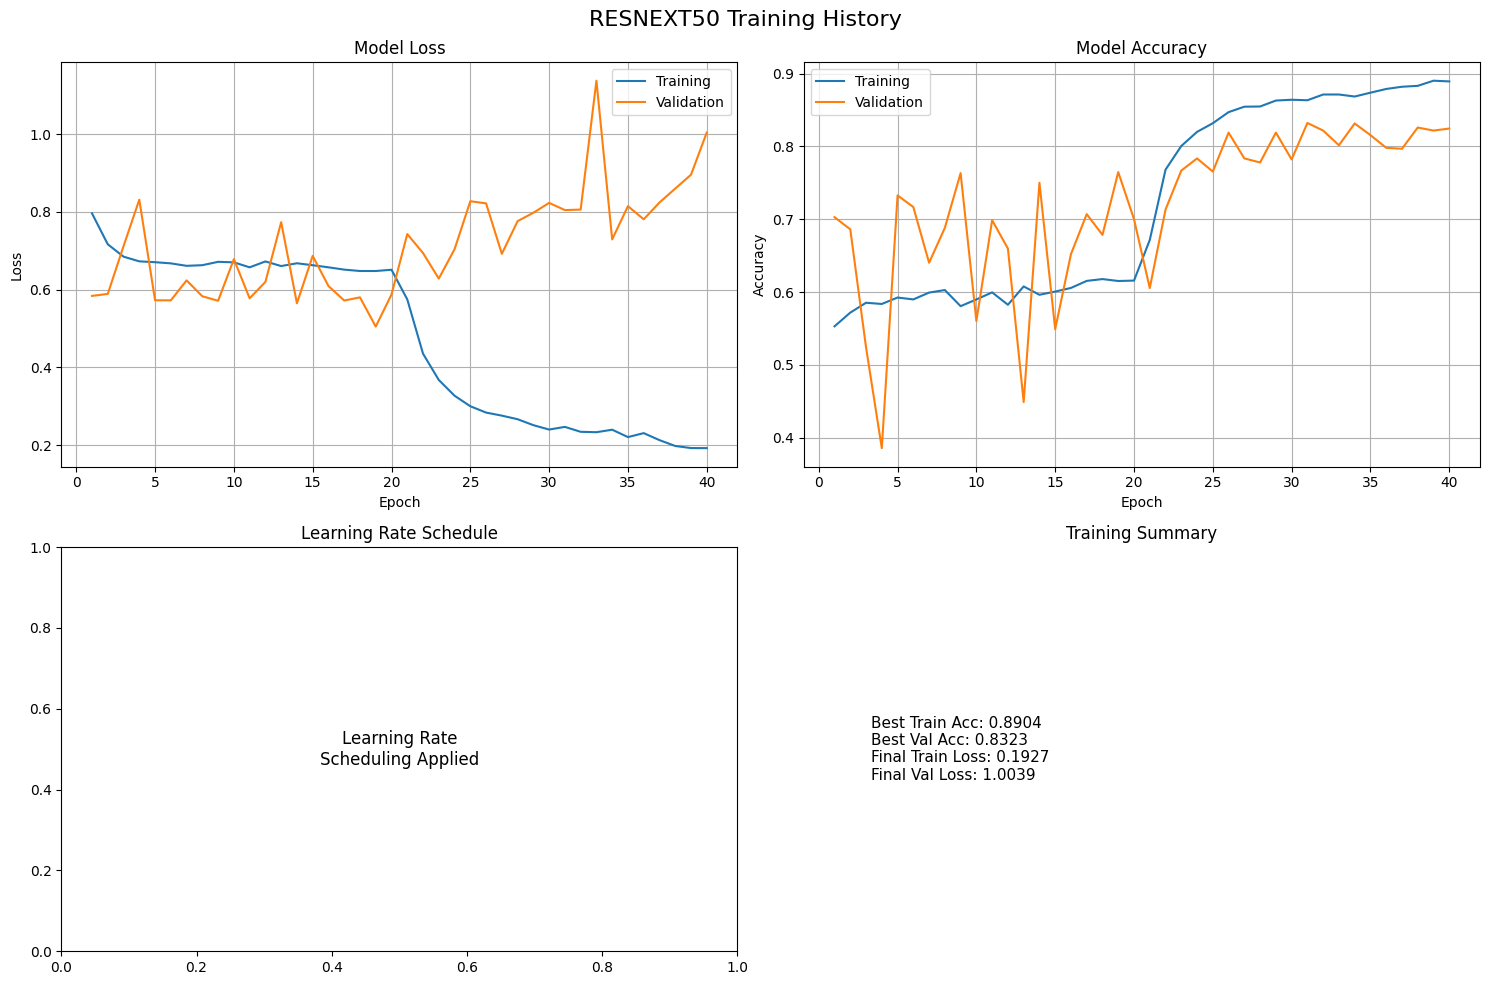

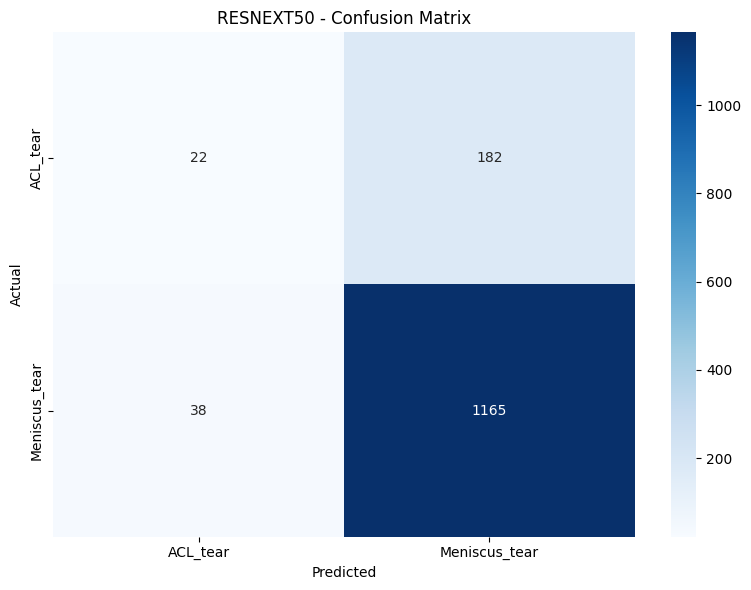

Evaluating densenet201...


Evaluating: 100%|██████████| 88/88 [00:05<00:00, 15.52it/s]




DENSENET201 Results:
Accuracy: 0.8600
Macro AUC: 0.6625


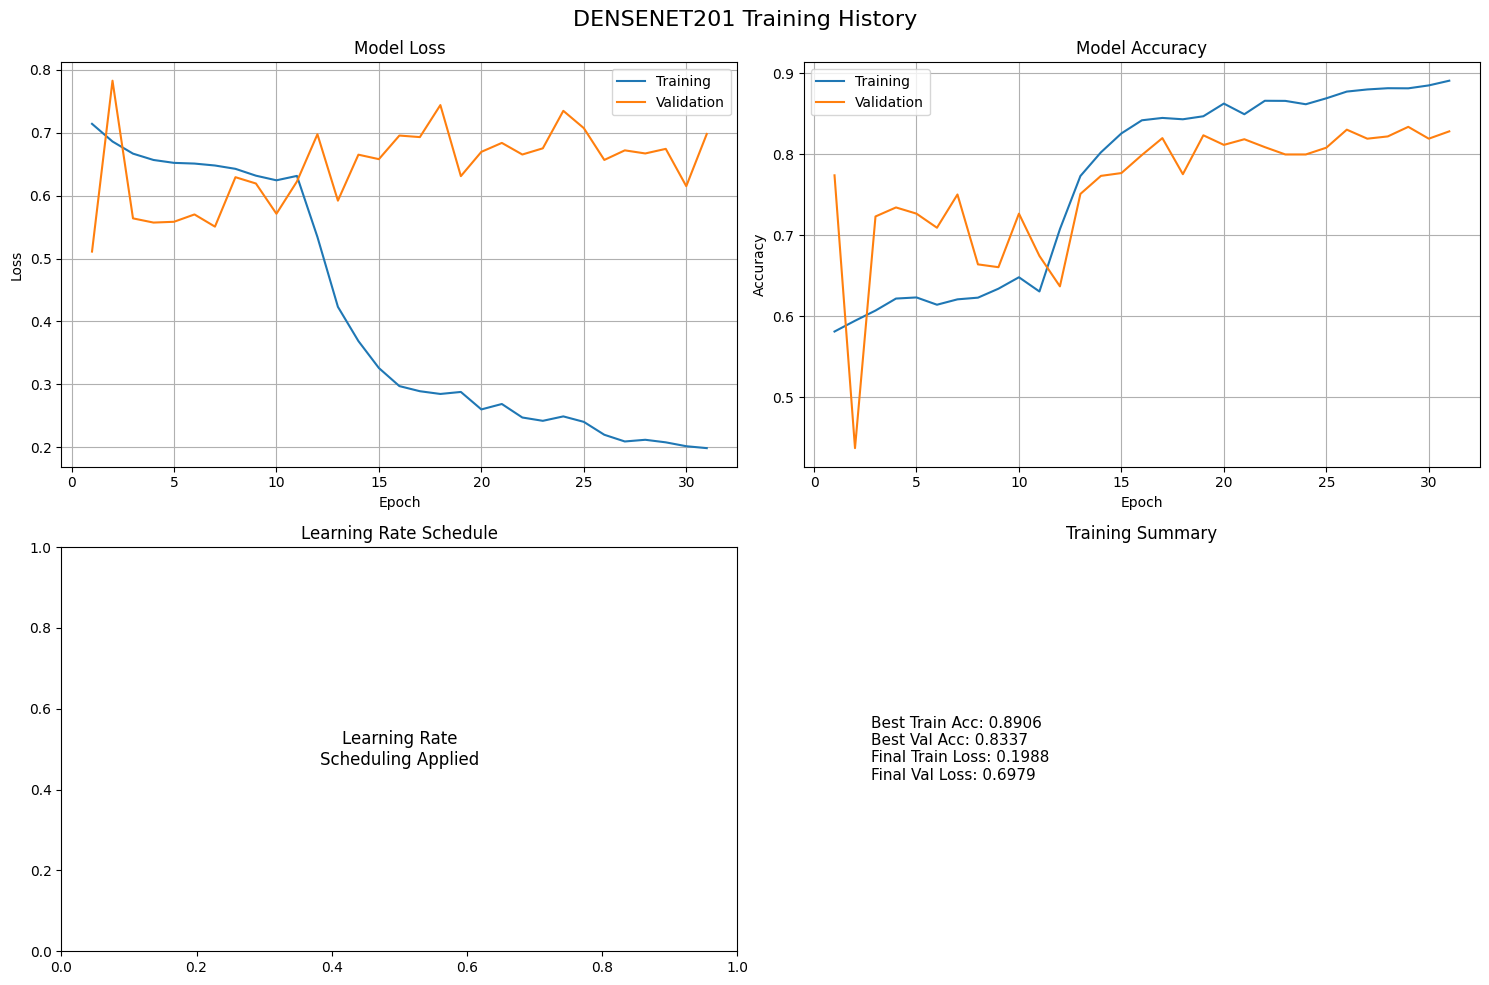

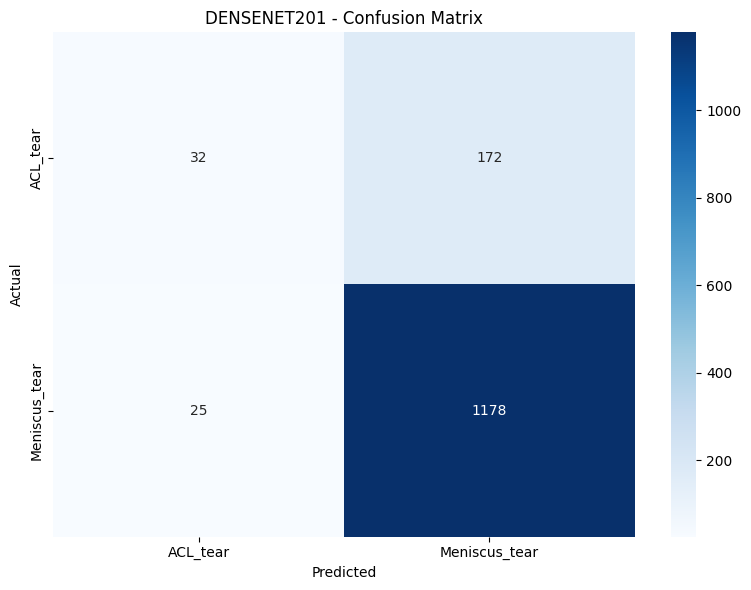

Evaluating efficientnet_b7...


Evaluating: 100%|██████████| 88/88 [00:08<00:00, 10.88it/s]




EFFICIENTNET_B7 Results:
Accuracy: 0.8550
Macro AUC: 0.5000


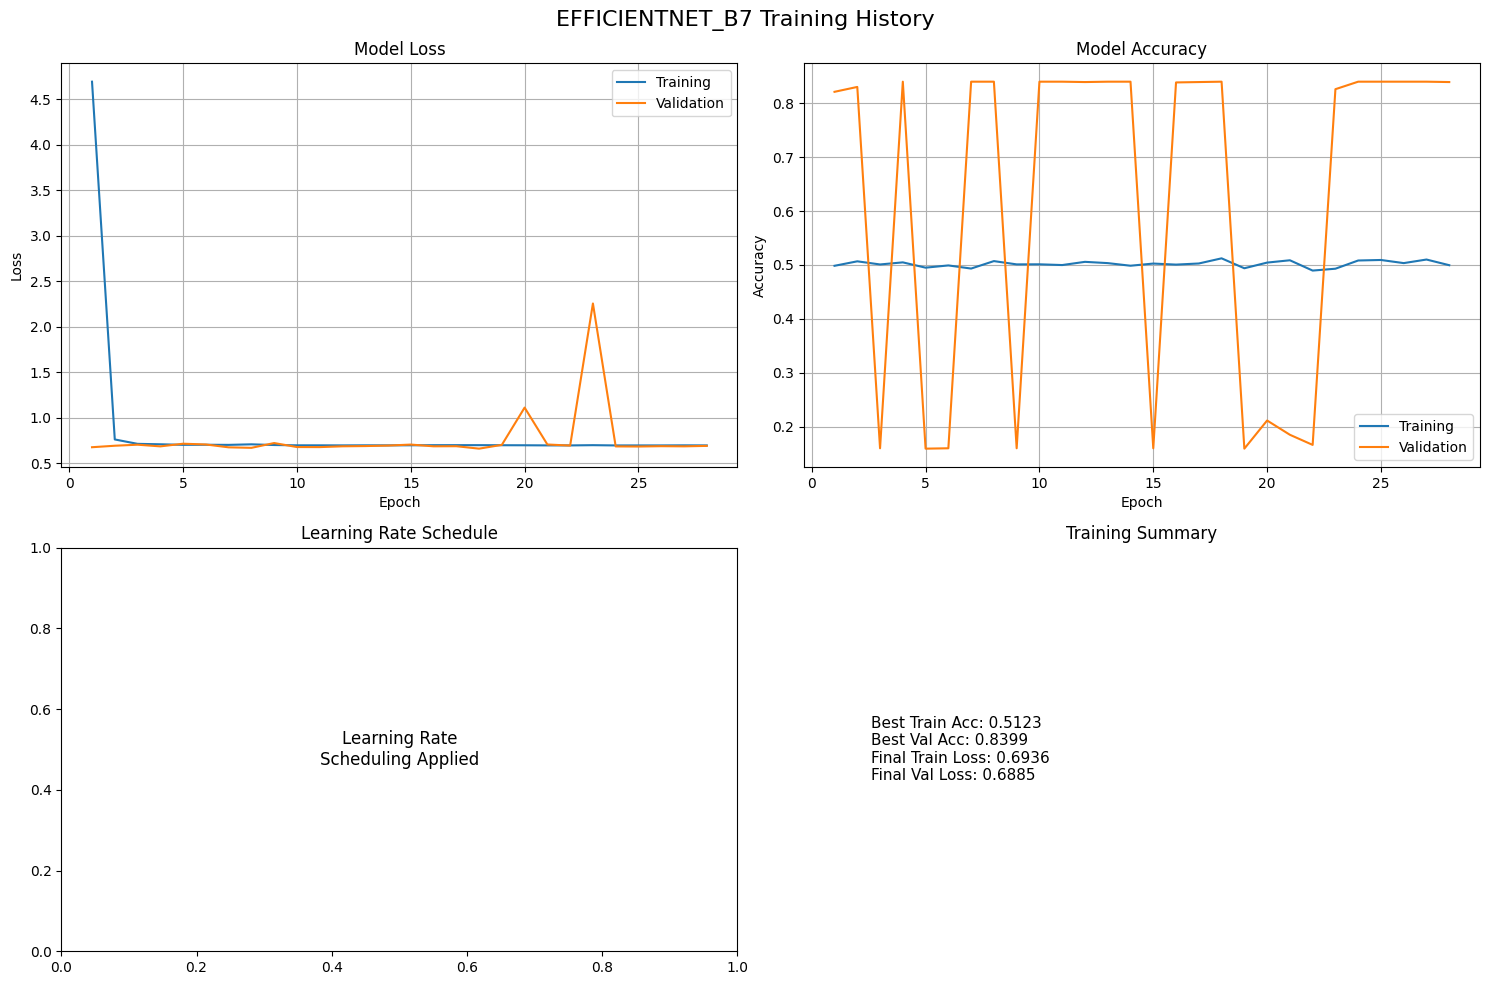

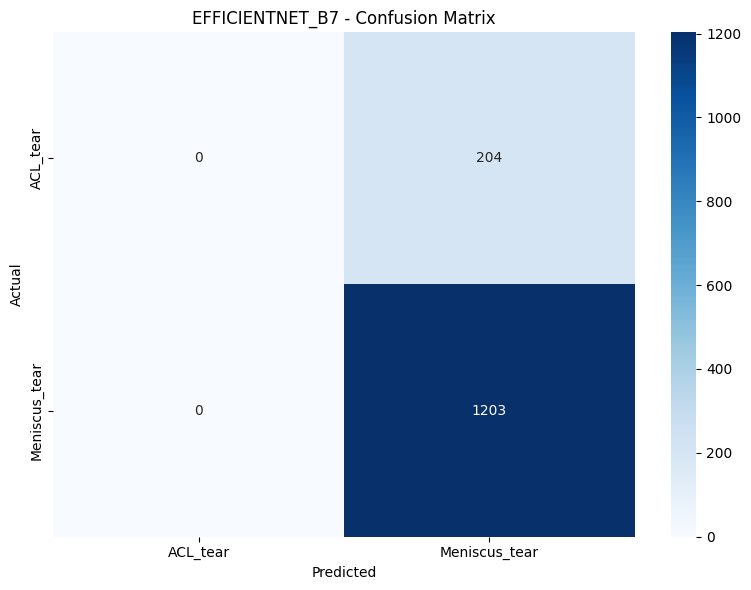

Evaluating xception...


Evaluating: 100%|██████████| 88/88 [00:04<00:00, 19.62it/s]




XCEPTION Results:
Accuracy: 0.7889
Macro AUC: 0.5870


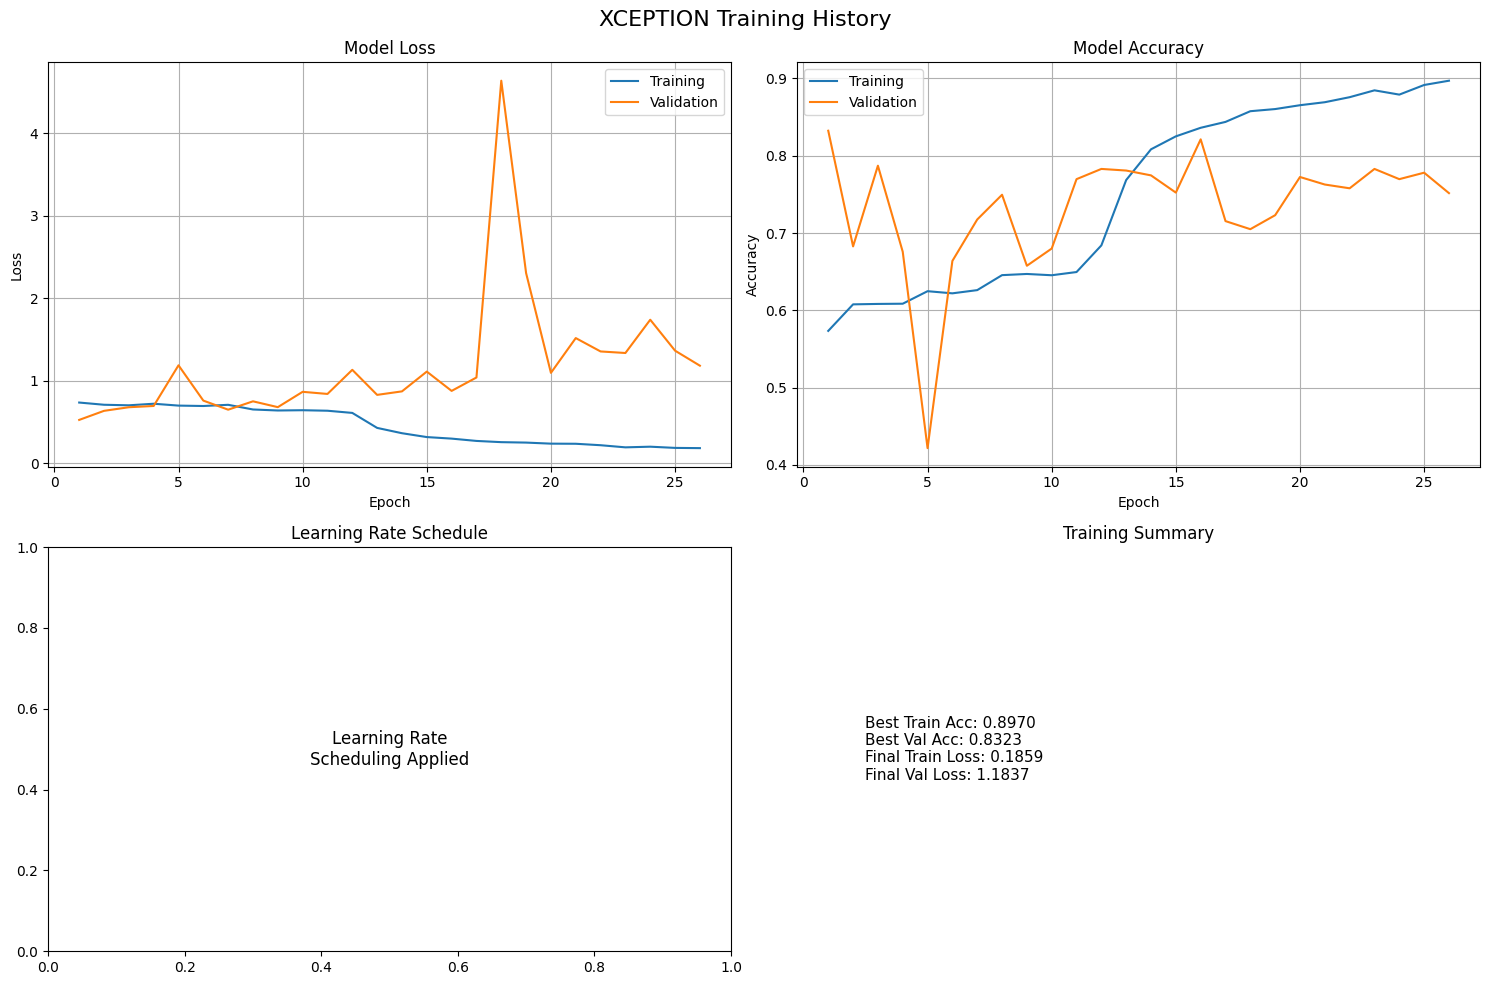

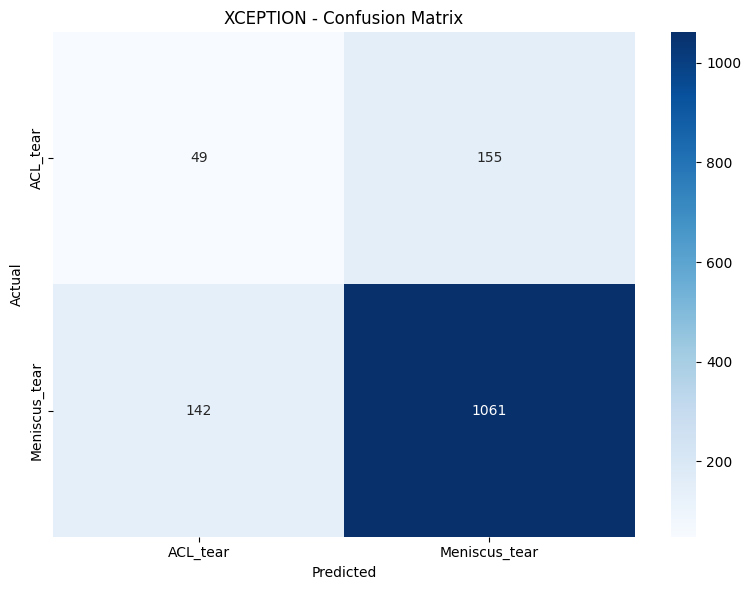


STEP 2.1: Base Model Comparison

MODEL COMPARISON SUMMARY
          Model  Accuracy  Macro AUC  Precision (Macro)  Recall (Macro)  F1-Score (Macro)
      Resnext50    0.8436     0.6051             0.6158          0.5381            0.5402
    Densenet201    0.8600     0.6625             0.7170          0.5680            0.5840
Efficientnet_b7    0.8550     0.5000             0.4275          0.5000            0.4609
       Xception    0.7889     0.5870             0.5645          0.5611            0.5627


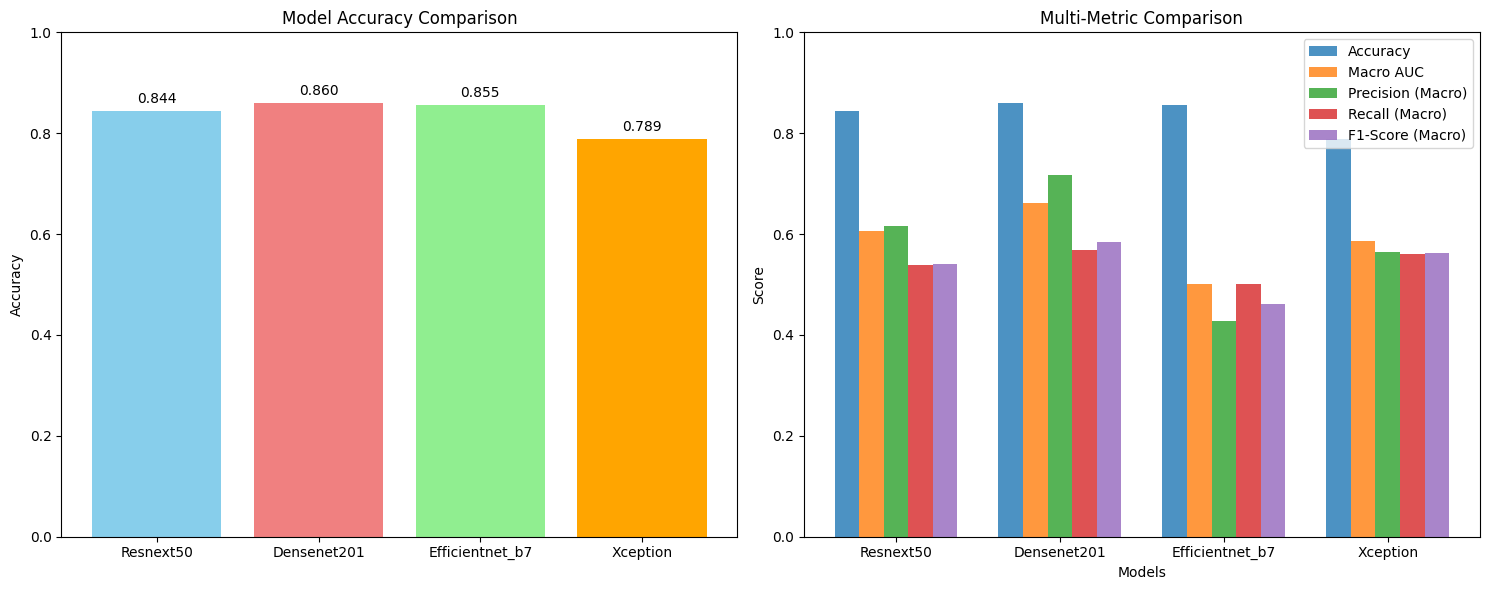

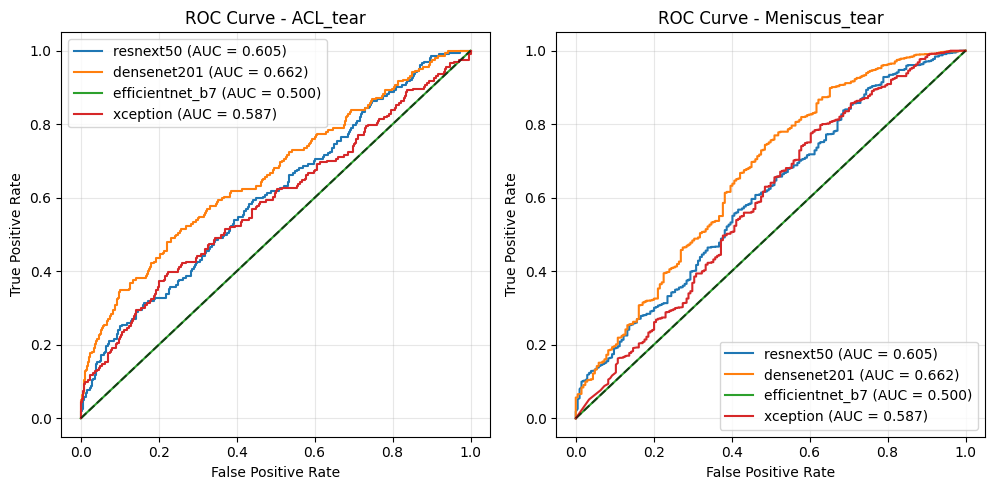


Base model evaluation completed for 4 models.
GPU memory used: 1.60 GB
GPU memory cached: 1.77 GB


In [77]:
# Execute Complete Pipeline (PyTorch)

# Configuration
QUICK_MODE = False  # Set to False for full optimization with genetic algorithm
EPOCHS = 10 if QUICK_MODE else 40
OPTIMIZE_HYPERPARAMS = False if QUICK_MODE else True

print(f"Running in {'QUICK' if QUICK_MODE else 'FULL'} mode")
print(f"Epochs: {EPOCHS}")
print(f"Hyperparameter optimization: {OPTIMIZE_HYPERPARAMS}")
print(f"Device: {device}")
print("\n" + "="*60)
print("STARTING COMPLETE ENSEMBLE LEARNING PIPELINE (PyTorch)")
print("="*60)

# Step 1: Train all base models
print("\nSTEP 1: Training Base Models")
print("-" * 40)

trained_models, training_histories = trainer.train_all_models(
    optimize_hyperparams=OPTIMIZE_HYPERPARAMS, 
    epochs=EPOCHS
)

print(f"\nTrained {len(trained_models)} base models successfully.")

# Step 2: Evaluate individual base models
print("\nSTEP 2: Evaluating Base Models")
print("-" * 40)

base_model_results = {}
for model_name, model in trained_models.items():
    try:
        # Get test predictions
        y_true, y_pred, y_pred_proba = trainer.evaluate_model(model, test_loader, model_name)
        
        # Create results dictionary in the same format as evaluator expects
        accuracy = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, target_names=evaluator.class_names, output_dict=True)
        
        # Calculate AUC scores
        auc_scores = []
        try:
            for i in range(len(evaluator.class_names)):
                y_true_binary = (y_true == i).astype(int)
                auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                auc_scores.append(auc)
            macro_auc = np.mean(auc_scores)
        except:
            auc_scores = []
            macro_auc = 0
        
        cm = confusion_matrix(y_true, y_pred)
        
        results = {
            'model_name': model_name,
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'auc_scores': auc_scores,
            'macro_auc': macro_auc,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        base_model_results[model_name] = results
        
        # Print results
        print(f"\n{model_name.upper()} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro AUC: {macro_auc:.4f}")
        
        # Plot training history
        evaluator.plot_training_history(training_histories[model_name], model_name)
        
        # Plot confusion matrix
        evaluator.plot_confusion_matrix(results['confusion_matrix'], model_name)
        
        # Clear GPU memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Compare base models
if base_model_results:
    print("\nSTEP 2.1: Base Model Comparison")
    comparison_df = evaluator.compare_models(base_model_results)
    
    # Plot ROC curves
    evaluator.plot_roc_curves(base_model_results)

print(f"\nBase model evaluation completed for {len(base_model_results)} models.")

# Memory management
if torch.cuda.is_available():
    print(f"GPU memory used: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved(device) / 1024**3:.2f} GB")



STEP 3: Creating Ensemble Models
----------------------------------------

3.1: Soft Voting Ensemble

Performing soft voting ensemble...
Extracting features from base models...
Extracting features from resnext50...

3.1: Soft Voting Ensemble

Performing soft voting ensemble...
Extracting features from base models...
Extracting features from resnext50...


Extracting resnext50: 100%|██████████| 90/90 [00:04<00:00, 20.83it/s]


Extracting features from densenet201...


Extracting densenet201: 100%|██████████| 90/90 [00:05<00:00, 17.00it/s]


Extracting features from efficientnet_b7...


Extracting efficientnet_b7: 100%|██████████| 90/90 [00:08<00:00, 10.17it/s]


Extracting features from xception...


Extracting xception: 100%|██████████| 90/90 [00:03<00:00, 24.83it/s]




ENSEMBLE EVALUATION: SOFT VOTING
Ensemble Accuracy: 0.8345

Classification Report:
               precision    recall  f1-score   support

     ACL_tear       0.40      0.30      0.34       204
Meniscus_tear       0.89      0.92      0.91      1222

     accuracy                           0.83      1426
    macro avg       0.64      0.61      0.62      1426
 weighted avg       0.82      0.83      0.83      1426

AUC for ACL_tear: 0.7601
AUC for Meniscus_tear: 0.7601
Macro-averaged AUC: 0.7601


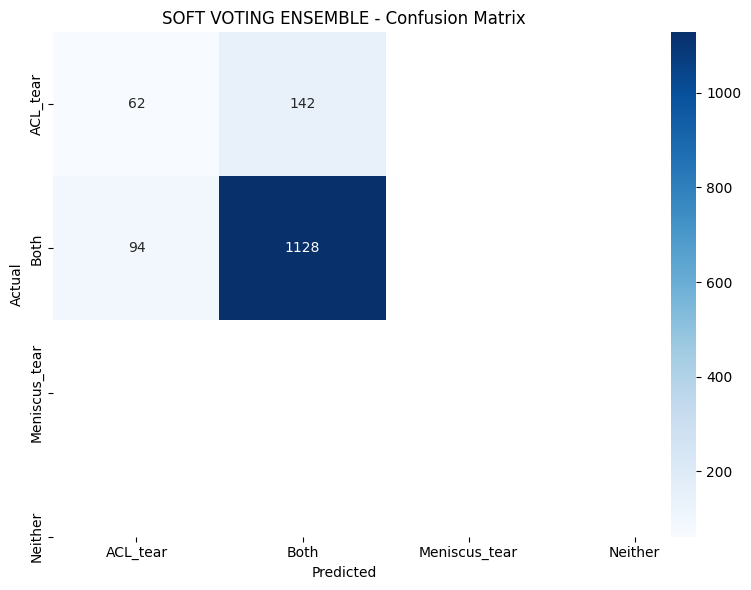


3.2: Hard Voting Ensemble

Performing hard voting ensemble...
Extracting features from base models...
Extracting features from resnext50...


Extracting resnext50: 100%|██████████| 90/90 [00:03<00:00, 22.65it/s]


Extracting features from densenet201...


Extracting densenet201: 100%|██████████| 90/90 [00:05<00:00, 17.15it/s]


Extracting features from efficientnet_b7...


Extracting efficientnet_b7: 100%|██████████| 90/90 [00:08<00:00, 10.19it/s]


Extracting features from xception...


Extracting xception: 100%|██████████| 90/90 [00:04<00:00, 20.36it/s]




ENSEMBLE EVALUATION: HARD VOTING
Ensemble Accuracy: 0.7630

Classification Report:
               precision    recall  f1-score   support

     ACL_tear       0.31      0.54      0.39       204
Meniscus_tear       0.91      0.80      0.85      1222

     accuracy                           0.76      1426
    macro avg       0.61      0.67      0.62      1426
 weighted avg       0.83      0.76      0.79      1426



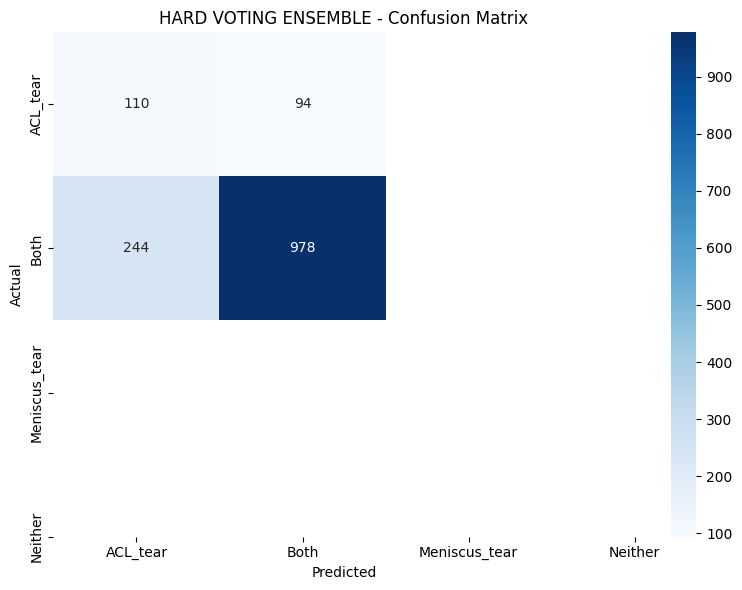


3.3: Weighted Ensemble

Creating weighted ensemble based on accuracy...
Extracting features from base models...
Extracting features from resnext50...


Extracting resnext50: 100%|██████████| 89/89 [00:04<00:00, 22.20it/s]


Extracting features from densenet201...


Extracting densenet201: 100%|██████████| 89/89 [00:04<00:00, 19.42it/s]


Extracting features from efficientnet_b7...


Extracting efficientnet_b7: 100%|██████████| 89/89 [00:08<00:00, 10.21it/s]


Extracting features from xception...


Extracting xception: 100%|██████████| 89/89 [00:04<00:00, 20.43it/s]



resnext50 weight (accuracy): 0.8172
densenet201 weight (accuracy): 0.6972
efficientnet_b7 weight (accuracy): 0.7156
xception weight (accuracy): 0.8412
Normalized weights: {'resnext50': np.float64(0.26608455882352944), 'densenet201': np.float64(0.2270220588235294), 'efficientnet_b7': np.float64(0.23299632352941177), 'xception': np.float64(0.27389705882352944)}
Extracting features from base models...
Extracting features from resnext50...


Extracting resnext50: 100%|██████████| 90/90 [00:04<00:00, 22.27it/s]


Extracting features from densenet201...


Extracting densenet201: 100%|██████████| 90/90 [00:05<00:00, 16.96it/s]


Extracting features from efficientnet_b7...


Extracting efficientnet_b7: 100%|██████████| 90/90 [00:08<00:00, 11.13it/s]


Extracting features from xception...


Extracting xception: 100%|██████████| 90/90 [00:04<00:00, 20.29it/s]




ENSEMBLE EVALUATION: WEIGHTED ENSEMBLE
Ensemble Accuracy: 0.8366

Classification Report:
               precision    recall  f1-score   support

     ACL_tear       0.40      0.28      0.33       204
Meniscus_tear       0.89      0.93      0.91      1222

     accuracy                           0.84      1426
    macro avg       0.64      0.60      0.62      1426
 weighted avg       0.82      0.84      0.82      1426

AUC for ACL_tear: 0.7589
AUC for Meniscus_tear: 0.7589
Macro-averaged AUC: 0.7589


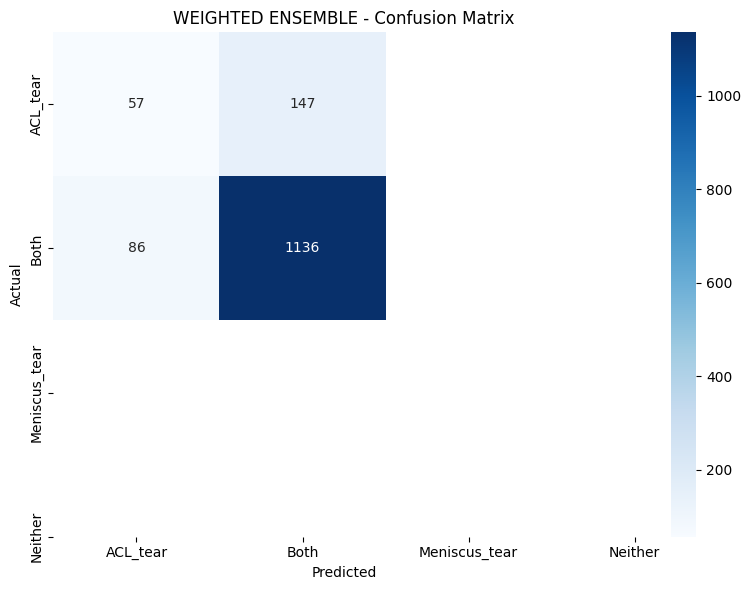


3.4: Meta-learner Ensemble (Skipped in QUICK_MODE)

Ensemble evaluation completed for 3 ensemble methods.

Final GPU memory used: 0.84 GB
Final GPU memory cached: 1.28 GB


In [57]:
# Step 3: Create and Evaluate Ensemble Models (PyTorch)
print("\nSTEP 3: Creating Ensemble Models")
print("-" * 40)

if len(trained_models) >= 2:  # Need at least 2 models for ensemble
    # Initialize ensemble
    model_list = list(trained_models.values())
    model_names = list(trained_models.keys())
    
    ensemble = PyTorchSequentialEnsemble(
        base_models=model_list,
        model_names=model_names,
        label_encoder=train_dataset.label_encoder,
        device=device
    )
    
    # Get true test labels for evaluation
    y_test_true = []
    for _, target in test_loader:
        y_test_true.extend(target.numpy())
    y_test_true = np.array(y_test_true)
    
    ensemble_results = {}
    
    # 3.1: Simple Soft Voting Ensemble
    print("\n3.1: Soft Voting Ensemble")
    try:
        soft_pred, soft_pred_proba = ensemble.simple_voting_ensemble(
            test_loader, voting_type='soft'
        )
        
        # Ensure same length
        min_len = min(len(y_test_true), len(soft_pred))
        y_test_true_trimmed = y_test_true[:min_len]
        soft_pred_trimmed = soft_pred[:min_len]
        soft_pred_proba_trimmed = soft_pred_proba[:min_len] if soft_pred_proba is not None else None
        
        soft_results = ensemble.evaluate_ensemble(
            y_test_true_trimmed, soft_pred_trimmed, soft_pred_proba_trimmed, "Soft Voting"
        )
        ensemble_results['soft_voting'] = soft_results
        
        # Plot confusion matrix
        evaluator.plot_confusion_matrix(soft_results['confusion_matrix'], "Soft Voting Ensemble")
        
        # Clear memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"Error with soft voting ensemble: {e}")
        import traceback
        traceback.print_exc()
    
    # 3.2: Hard Voting Ensemble
    print("\n3.2: Hard Voting Ensemble")
    try:
        hard_pred, hard_pred_proba = ensemble.simple_voting_ensemble(
            test_loader, voting_type='hard'
        )
        
        # Ensure same length
        min_len = min(len(y_test_true), len(hard_pred))
        y_test_true_trimmed = y_test_true[:min_len]
        hard_pred_trimmed = hard_pred[:min_len]
        
        hard_results = ensemble.evaluate_ensemble(
            y_test_true_trimmed, hard_pred_trimmed, None, "Hard Voting"
        )
        ensemble_results['hard_voting'] = hard_results
        
        # Plot confusion matrix
        evaluator.plot_confusion_matrix(hard_results['confusion_matrix'], "Hard Voting Ensemble")
        
        # Clear memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"Error with hard voting ensemble: {e}")
        import traceback
        traceback.print_exc()
    
    # 3.3: Weighted Ensemble (based on accuracy)
    print("\n3.3: Weighted Ensemble")
    try:
        weighted_pred, weighted_pred_proba = ensemble.weighted_ensemble(
            val_loader, test_loader, method='accuracy'
        )
        
        # Ensure same length
        min_len = min(len(y_test_true), len(weighted_pred))
        y_test_true_trimmed = y_test_true[:min_len]
        weighted_pred_trimmed = weighted_pred[:min_len]
        weighted_pred_proba_trimmed = weighted_pred_proba[:min_len] if weighted_pred_proba is not None else None
        
        weighted_results = ensemble.evaluate_ensemble(
            y_test_true_trimmed, weighted_pred_trimmed, weighted_pred_proba_trimmed, "Weighted Ensemble"
        )
        ensemble_results['weighted'] = weighted_results
        
        # Plot confusion matrix
        evaluator.plot_confusion_matrix(weighted_results['confusion_matrix'], "Weighted Ensemble")
        
        # Clear memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"Error with weighted ensemble: {e}")
        import traceback
        traceback.print_exc()
    
    # 3.4: Meta-learner Ensemble (if not in quick mode)
    if not QUICK_MODE:
        print("\n3.4: Meta-learner Ensemble")
        try:
            meta_pred, meta_pred_proba, meta_history = ensemble.meta_learner_ensemble(
                train_loader, val_loader, test_loader
            )
            
            # Ensure same length
            min_len = min(len(y_test_true), len(meta_pred))
            y_test_true_trimmed = y_test_true[:min_len]
            meta_pred_trimmed = meta_pred[:min_len]
            meta_pred_proba_trimmed = meta_pred_proba[:min_len] if meta_pred_proba is not None else None
            
            meta_results = ensemble.evaluate_ensemble(
                y_test_true_trimmed, meta_pred_trimmed, meta_pred_proba_trimmed, "Meta-learner Ensemble"
            )
            ensemble_results['meta_learner'] = meta_results
            
            # Plot confusion matrix
            evaluator.plot_confusion_matrix(meta_results['confusion_matrix'], "Meta-learner Ensemble")
            
            # Plot meta-model training history
            plt.figure(figsize=(12, 4))
            
            epochs = range(1, len(meta_history['train_acc']) + 1)
            
            plt.subplot(1, 2, 1)
            plt.plot(epochs, meta_history['train_acc'], label='Training')
            plt.plot(epochs, meta_history['val_acc'], label='Validation')
            plt.title('Meta-model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(epochs, meta_history['train_loss'], label='Training')
            plt.plot(epochs, meta_history['val_loss'], label='Validation')
            plt.title('Meta-model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
            
            # Clear memory
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"Error with meta-learner ensemble: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\n3.4: Meta-learner Ensemble (Skipped in QUICK_MODE)")
    
    print(f"\nEnsemble evaluation completed for {len(ensemble_results)} ensemble methods.")
    
    # Final memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"\nFinal GPU memory used: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
        print(f"Final GPU memory cached: {torch.cuda.memory_reserved(device) / 1024**3:.2f} GB")
    
else:
    print("Not enough trained models for ensemble learning.")
    ensemble_results = {}



STEP 4: Final Results Summary

COMPREHENSIVE MODEL COMPARISON (PyTorch)
--------------------------------------------------------------------------------
                       accuracy  macro_auc  precision  recall  f1_score
Ensemble: Soft Voting    0.8345     0.7601     0.6428  0.6135    0.6249
Ensemble: Hard Voting    0.7630     0.0000     0.6115  0.6698    0.6235
Ensemble: Weighted       0.8366     0.7589     0.6420  0.6045    0.6178

BEST PERFORMING MODELS:
Highest Accuracy: Ensemble: Weighted (0.8366)
Highest AUC: Ensemble: Soft Voting (0.7601)
Highest F1-Score: Ensemble: Soft Voting (0.6249)


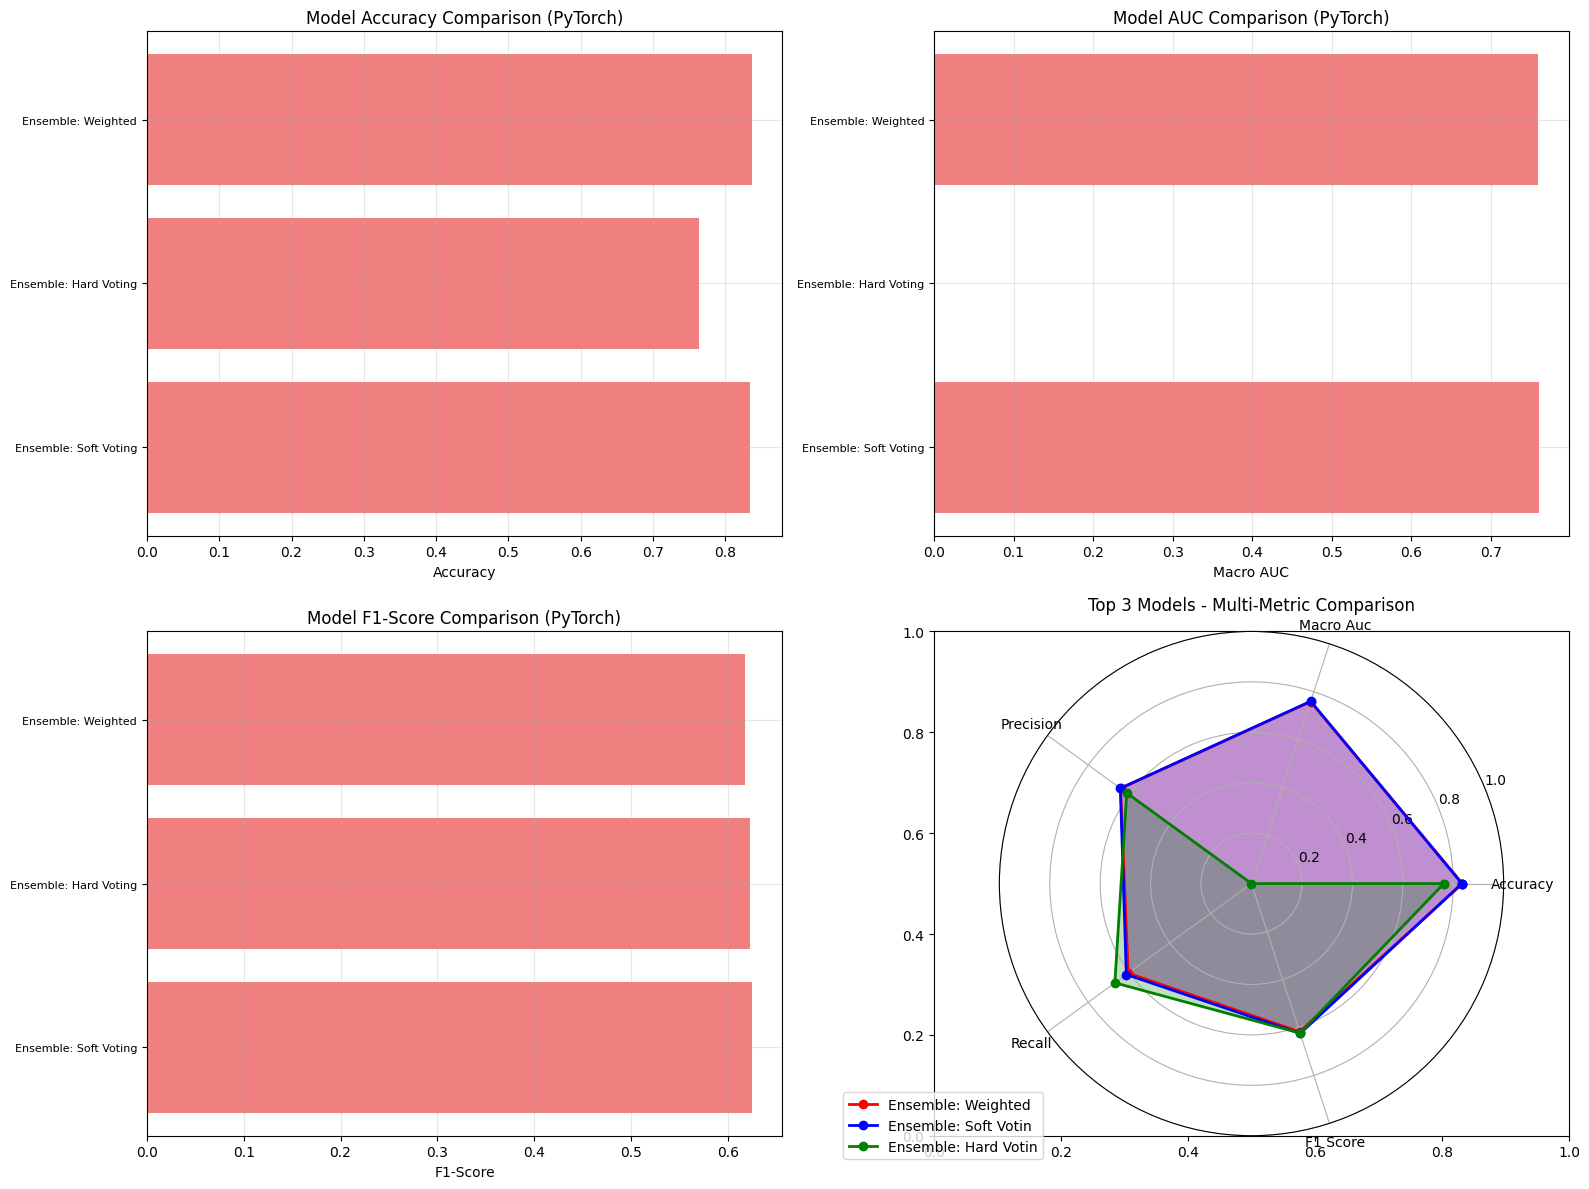


OPTIMIZED HYPERPARAMETERS (PyTorch):
----------------------------------------

RESNEXT50:
  learning_rate: 0.0001
  dropout_rate: 0.4
  weight_decay: 0.0001
  batch_size: 16

DENSENET201:
  learning_rate: 0.0001
  dropout_rate: 0.6
  weight_decay: 0.0001
  batch_size: 16

EFFICIENTNET_B7:
  learning_rate: 5e-05
  dropout_rate: 0.5
  weight_decay: 0.0001
  batch_size: 8

XCEPTION:
  learning_rate: 0.0001
  dropout_rate: 0.3
  weight_decay: 0.0001
  batch_size: 16

PYTORCH PIPELINE EXECUTION SUMMARY:
Framework: PyTorch 2.8.0+cu126
Device used: cuda
Total base models trained: 4
Total ensemble methods tested: 3
Total evaluation metrics computed: 3
Best overall accuracy: 0.8366
Best overall AUC: 0.7601
Best overall F1-score: 0.6249

Note: Pipeline was run in QUICK mode. For production use, consider:
- Setting QUICK_MODE = False for full optimization
- Increasing EPOCHS for better convergence
- Running genetic algorithm optimization
- Using larger population sizes and more generations
- Ena

In [58]:
# Step 4: Final Results Summary and Comparison (PyTorch)
print("\nSTEP 4: Final Results Summary")
print("="*60)

# Combine all results for comprehensive comparison
all_results = {}

# Add base model results
for model_name, results in base_model_results.items():
    all_results[f"Base: {model_name.capitalize()}"] = {
        'accuracy': results['accuracy'],
        'macro_auc': results['macro_auc'],
        'precision': results['classification_report']['macro avg']['precision'],
        'recall': results['classification_report']['macro avg']['recall'],
        'f1_score': results['classification_report']['macro avg']['f1-score']
    }

# Add ensemble results
for ensemble_name, results in ensemble_results.items():
    all_results[f"Ensemble: {ensemble_name.replace('_', ' ').title()}"] = {
        'accuracy': results['accuracy'],
        'macro_auc': results['macro_auc'],
        'precision': results['classification_report']['macro avg']['precision'],
        'recall': results['classification_report']['macro avg']['recall'],
        'f1_score': results['classification_report']['macro avg']['f1-score']
    }

# Create comprehensive comparison
if all_results:
    final_comparison = pd.DataFrame.from_dict(all_results, orient='index')
    final_comparison = final_comparison.round(4)
    
    print("\nCOMPREHENSIVE MODEL COMPARISON (PyTorch)")
    print("-" * 80)
    print(final_comparison.to_string(float_format='%.4f'))
    
    # Find best performing models
    best_accuracy = final_comparison['accuracy'].max()
    best_auc = final_comparison['macro_auc'].max()
    best_f1 = final_comparison['f1_score'].max()
    
    best_accuracy_model = final_comparison[final_comparison['accuracy'] == best_accuracy].index[0]
    best_auc_model = final_comparison[final_comparison['macro_auc'] == best_auc].index[0]
    best_f1_model = final_comparison[final_comparison['f1_score'] == best_f1].index[0]
    
    print(f"\nBEST PERFORMING MODELS:")
    print(f"Highest Accuracy: {best_accuracy_model} ({best_accuracy:.4f})")
    print(f"Highest AUC: {best_auc_model} ({best_auc:.4f})")
    print(f"Highest F1-Score: {best_f1_model} ({best_f1:.4f})")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy comparison
    axes[0, 0].barh(range(len(final_comparison)), final_comparison['accuracy'], 
                    color=['lightblue' if 'Base:' in idx else 'lightcoral' for idx in final_comparison.index])
    axes[0, 0].set_yticks(range(len(final_comparison)))
    axes[0, 0].set_yticklabels(final_comparison.index, fontsize=8)
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_title('Model Accuracy Comparison (PyTorch)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUC comparison
    axes[0, 1].barh(range(len(final_comparison)), final_comparison['macro_auc'], 
                    color=['lightblue' if 'Base:' in idx else 'lightcoral' for idx in final_comparison.index])
    axes[0, 1].set_yticks(range(len(final_comparison)))
    axes[0, 1].set_yticklabels(final_comparison.index, fontsize=8)
    axes[0, 1].set_xlabel('Macro AUC')
    axes[0, 1].set_title('Model AUC Comparison (PyTorch)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1-Score comparison
    axes[1, 0].barh(range(len(final_comparison)), final_comparison['f1_score'], 
                    color=['lightblue' if 'Base:' in idx else 'lightcoral' for idx in final_comparison.index])
    axes[1, 0].set_yticks(range(len(final_comparison)))
    axes[1, 0].set_yticklabels(final_comparison.index, fontsize=8)
    axes[1, 0].set_xlabel('F1-Score')
    axes[1, 0].set_title('Model F1-Score Comparison (PyTorch)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Multi-metric radar chart for top 3 models
    top_3_models = final_comparison.nlargest(3, 'accuracy')
    
    metrics = ['accuracy', 'macro_auc', 'precision', 'recall', 'f1_score']
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    ax = plt.subplot(2, 2, 4, projection='polar')
    
    colors = ['red', 'blue', 'green']
    for i, (model_name, row) in enumerate(top_3_models.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name[:20], color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
    ax.set_ylim(0, 1)
    ax.set_title('Top 3 Models - Multi-Metric Comparison')
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Print hyperparameters used (if optimization was performed)
if trainer.best_params:
    print("\nOPTIMIZED HYPERPARAMETERS (PyTorch):")
    print("-" * 40)
    for model_name, params in trainer.best_params.items():
        print(f"\n{model_name.upper()}:")
        for param, value in params.items():
            if param != 'fitness':
                print(f"  {param}: {value}")
        if 'fitness' in params:
            print(f"  Validation Accuracy: {params['fitness']:.4f}")

# Summary statistics
print("\nPYTORCH PIPELINE EXECUTION SUMMARY:")
print("="*50)
print(f"Framework: PyTorch {torch.__version__}")
print(f"Device used: {device}")
print(f"Total base models trained: {len(trained_models)}")
print(f"Total ensemble methods tested: {len(ensemble_results)}")
print(f"Total evaluation metrics computed: {len(all_results)}")

if all_results:
    print(f"Best overall accuracy: {final_comparison['accuracy'].max():.4f}")
    print(f"Best overall AUC: {final_comparison['macro_auc'].max():.4f}")
    print(f"Best overall F1-score: {final_comparison['f1_score'].max():.4f}")

if QUICK_MODE:
    print("\nNote: Pipeline was run in QUICK mode. For production use, consider:")
    print("- Setting QUICK_MODE = False for full optimization")
    print("- Increasing EPOCHS for better convergence")
    print("- Running genetic algorithm optimization")
    print("- Using larger population sizes and more generations")
    print("- Enabling meta-learner ensemble")

# Final memory cleanup and statistics
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nFinal GPU memory statistics:")
    print(f"- Memory allocated: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
    print(f"- Memory cached: {torch.cuda.memory_reserved(device) / 1024**3:.2f} GB")
    print(f"- Max memory allocated: {torch.cuda.max_memory_allocated(device) / 1024**3:.2f} GB")
 
print("\n" + "="*60)
print("PyTorch ENSEMBLE LEARNING PIPELINE COMPLETED SUCCESSFULLY!")